<a href="https://colab.research.google.com/github/gu725/pufa/blob/main/reserve_scheduling_118bus_baseline_solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/gdrive')

# Insert the directory
import sys
# sys.path.insert(0,'/content/gdrive/MyDrive/Inbox/reserve_fromLocal')

Mounted at /content/gdrive


In [ ]:
!pip install pyomo
!apt-get -qq install gcc g++ gfortran git patch wget pkg-config liblapack-dev libmetis-dev
# !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!wget -N -q "https://portal.ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!apt-get install -y -qq glpk-utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 5.6 MB/s eta 0:00:00
Selecting previously unselected package libmetis5:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libmetis5_5.1.0.dfsg-5_amd64.deb ...
Unpacking libmetis5:amd64 (5.1.0.dfsg-5) ...
Selecting previously unselected package libmetis-dev.
Preparing to unpack .../libmetis-dev_5.1.0.dfsg-5_amd64.deb ...
Unpacking libmetis-dev (5.1.0.dfsg-5) ...
Setting up libmetis5:amd64 (5.1.0.dfsg-5) ...
Setting up libmetis-dev (5.1.0.dfsg-5) ...
Processing triggers for libc-bin (2.27-3ubuntu1.6) ...
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124026 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_

In [ ]:
from pyomo.environ import *
# GENERATE ALL DATA
import numpy as np
from scipy.linalg import cholesky
from matplotlib import pyplot as plt
%matplotlib inline

parentFolder = '/content/gdrive/MyDrive/Inbox/Simulation1/'

# params.py


In [ ]:
# params.py
# SET PARAMETERS THAT ARE GOING TO BE USED EVERYWHERE

# OPTIONS for caseID:
# no_wind: all generators are regular (controllable)
# wind_penetration: set one of the generators to be wind power
caseID = 'no_wind'

realTimeDemandStdevFactor = 0.05
inputDemandStdevFactor = 0.1

realTimeWindStdevFactor = 0.05
inputWindStdevFactor = 0.1

maxNumInstances = 50000
minNumInstances = 100

nnNumTestFactor = 0.1

nnNumTrain = 50000
nnNumPreTrain = 100
nnNumTest = 1000

maxNumScenarios = 500
minNumScenarios = 10
# use a small number to test if codes run correctly
# numScenarios = minNumScenarios

# to run on google colab, set parentFolder = '/content/gdrive/MyDrive/Your folder path/'
# to run locally:
# parentFolder = ''
paramsPath39Bus = parentFolder + '39bus/params/'
inputDemandPath39Bus = parentFolder + '39bus/inputDemand/'
savedPreTrainPath39Bus = parentFolder + '39bus/savedPreTrain/'
savedTrainPath39Bus = parentFolder + '39bus/savedTrain/'

paramsPath118Bus = parentFolder + '118bus/params/'
inputDemandPath118Bus = parentFolder + '118bus/dataset/'
savedPreTrainPath118Bus = parentFolder + '118bus/savedPreTrainModels/'
savedTrainPath118Bus = parentFolder + '118bus/savedTrainModels/'
summaryPath118Bus = parentFolder + '118bus/summary/'

reservesCostFactor = 1.5
windReservesCostFactor = 0.1

# The default max_iter is 3000
maximumIterations_glpk = 2500
tolerance_glpk = 1e-6

# number of scenarios for estimating cost of recourse stage (i.e., Q) in learning methods
numMCScenarios = 20

# then, generate an independent batch of scenarios for evaluating quality of solutions of ALL METHODS
numAnalyticalScenarios = 10000


# penalty parameters
gammaRes = 10
gammaGen = 1e3
gammaLine = 1e3

delta_line = 0.95
delta_gen = 0.95

theta_max = np.pi/2
theta_min = -theta_max

# data.py

In [ ]:
# # GENERATE ALL DATA
# import numpy as np
# from scipy.linalg import cholesky

# from params import *


def generateCorrMat(numBuses, numFactors):
    W = np.random.randn(numBuses, numFactors)
    S = W@W.T + np.diag(np.random.rand(1, numBuses))
    S = np.diag(1. / np.sqrt(np.diag(S))) @ S @ np.diag(1. / np.sqrt(np.diag(S)))
    S = np.round(S, 4)

    return S


def generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath):
    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = inputDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = generateCorrMat(numBuses, numBuses)
    np.save(inputDemandPath + 'demandCorrMat.npy', demandCorrMat)

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    totalNumInstances = nnNumTrain + nnNumPreTrain + nnNumTest
    stdNormalData = np.random.multivariate_normal([0.]*numBuses, np.eye(numBuses), totalNumInstances)
    allData = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), totalNumInstances, axis=-1)
    allData = allData.T

    # set zero loads to be zero
    allData[:, zeroLoads] = 0.

    # Alternative way to generate input demands for many instances
    # demandCorrMat = np.eye(numLoads)
    # demandCovMat = np.diag(inputDemandStdev)*demandCorrMat*np.diag(inputDemandStdev)
    # demandCovMat_chol
    # omega_d_tmp = np.random.multivariate_normal(0.0, 1.0, numInstances)
    # allData = demandCovMat_chol*omega_d_tmp + predMeanDemand

    nnTestData = allData[:nnNumTest, :]
    nnPreTrainData = allData[-nnNumPreTrain:, :]
    nnTrainData = allData[nnNumTest:-nnNumPreTrain, :]

    np.save(inputDemandPath + 'nnTrainData.npy', nnTrainData)
    np.save(inputDemandPath + 'nnPreTrainData.npy', nnPreTrainData)
    np.save(inputDemandPath + 'nnTestData.npy', nnTestData)


# generate {numScenarios} real-time demand scenarios for a particular instance
def generateRealTimeScenarios(predMeanDemand, numBuses, zeroLoads, numScenarios,
                              inputDemandPath, windPred=None):

    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = realTimeDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = np.load(inputDemandPath + 'demandCorrMat.npy')

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    stdNormalData = np.random.multivariate_normal([0.] * numBuses, np.eye(numBuses), numScenarios)
    d_omega = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), numScenarios, axis=-1)
    d_omega = d_omega.T

    # set zero load to be zero
    d_omega[:, zeroLoads] = 0.

    w_omega = None
    if caseID == 'wind_penetration' and windPred:
        realTimeWindStdev = realTimeWindStdevFactor * windPred
        # for zero stdev, set them to be small, i.e., 0.1
        realTimeWindStdev = np.where(realTimeWindStdev < 1e-5, 0.1, realTimeWindStdev)

        w_omega = np.random.multivariate_normal(windPred, np.diag(realTimeWindStdev), numScenarios)
        # w_omega = np.clip(w_omega, a_min=0., a_max=None)

    return d_omega, w_omega


# utilities118bus.py

In [43]:
# utilities.py
# UTILITY FUNCTIONS AND DEFINITIONS
import os
import numpy as np
import pandas as pd
import json

# from params import *


# create a new directory if it does not exist
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
        print("The new directory is created!")


# calculate row-wise l2 distance
def measure_relative_distance(v1, v2):
    distance_vec = np.linalg.norm(v1 - v2, axis=1) / np.linalg.norm(v1, axis=1)

    return np.mean(distance_vec)


def toIntList(numList):
    intList = [int(x) for x in numList]

    return intList


def identifyUniqueLines(ieeeNetwork, connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count += 1

    # The following codes only find out the repeated lines that have exactly the same order of nodes,
    # but do not deal with the case where [i,j] and [j,i] are also repeated lines
    # Luckily, by checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k] = val

    if ieeeNetwork == '118bus':
        repeated_lines = [[42, 49], [49, 54], [56, 59], [49, 66], [77, 80], [89, 90], [89, 92]]
        # For example, [42, 49] appears twice
        set1 = {}
        set2 = {}
        for k, val in all_lines.items():
            if val in repeated_lines and k in unique_lines:
                set1[val[0], val[1]] = k  # Record the repeated lines when they first appear
            if val in repeated_lines and k not in unique_lines:
                set2[val[0], val[1]] = k  # Record the repeated lines when they appear more than once
    else:
        repeated_lines = []

    return unique_lines, repeated_lines


# read data csv files
def readDataFromFiles(ieeeNetwork, paramsPath):
    print('==== Read data from files. ====')

    allBusesFileName = ieeeNetwork + '_BusData.csv'
    allGenFileName = ieeeNetwork + '_GenData.csv'
    BranchFileName = ieeeNetwork + '_BranchData.csv'

    bus_data_df = pd.read_csv(paramsPath + allBusesFileName, header=None)
    gen_data_df = pd.read_csv(paramsPath + allGenFileName, header=None)
    branch_data_df = pd.read_csv(paramsPath + BranchFileName, header=None)

    # *========== NETWORK TOPOLOGY ==========

    numBuses = bus_data_df.shape[0]
    numGen = gen_data_df.shape[0]
    numRegGen = numGen
    numWindGen = 0
    numLines = branch_data_df.shape[0]

    listOfNums = dict()
    listOfNums['numBuses'] = numBuses
    listOfNums['numGen'] = numGen
    listOfNums['numRegGen'] = numRegGen
    listOfNums['numWindGen'] = numWindGen
    listOfNums['numLines'] = numLines

    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()

    # all buses
    maskOutPQBus = [True if bus_data[i, 1] == 1 else False for i in range(bus_data.shape[0])]
    maskOutPVBus = [True if bus_data[i, 1] == 2 else False for i in range(bus_data.shape[0])]
    maskOutSlackBus = [True if bus_data[i, 1] == 3 else False for i in range(bus_data.shape[0])]

    # list of loads at a particular bus (P-Q bus)
    # PQBusList = bus_data[:, 0][maskOutPQBus]
    # loadList = PQBusList
    # listOfNums['numLoads'] = len(loadList)

    # list of regular generators at a particular bus (P-V bus)
    PVBusList = bus_data[:, 0][maskOutPVBus]
    regGenList = gen_data[:, 0].tolist()
    assert len(regGenList) == numGen

    regGenSet = [x - 1 for x in regGenList]
    nonRegGenSet = []
    for x in range(numBuses):
        if x not in regGenSet:
            nonRegGenSet.append(x)

    # slack bus
    slackBus = bus_data[:, 0][maskOutSlackBus][0]
    listOfNums['slackBusNo'] = int(slackBus)

    # check to see if these are type 4 bus
    # assert len(PQBusList) + len(PVBusList) + 1 == numBuses, print('add type 4 buses!')

    # list of wind generators at a particular bus
    windGenList = []
    # if caseID == "wind_penetration":
    # modify windGenList
    # modify regGenList if needed
    genList = list(regGenList) + windGenList

    # form connections as a list of tuples
    connections = []
    branches = branch_data[:, :2]
    for i in range(branches.shape[0]):
        connections.append([int(branches[i, 0]), int(branches[i, 1])])

    if ieeeNetwork == '118bus':
        unique_lines, repeated_lines = identifyUniqueLines(ieeeNetwork, connections)
    else:
        unique_lines, _ = identifyUniqueLines(ieeeNetwork, connections)
    # modify number of lines
    numUniqueLines = len(unique_lines)
    listOfNums['numUniqueLines'] = numUniqueLines

    # *========== DEMAND DATA ===========
    # form nominal demand data
    # note that loads and generators can connect to a same bus
    demandFactor = 1.0
    demand_data = bus_data[:, 2]/10
    demand_data *= demandFactor
    posDemands = []
    posDemandsList = []
    for i, d in enumerate(demand_data):
        if d > 0.:
            posDemands.append(d)
            posDemandsList.append(i + 1)
    # modify number of loads
    numPosDemands = len(posDemands)
    listOfNums['numPosDemands'] = numPosDemands

    # predMeanDemand = [0.0 if idx in regGenSet else x for idx, x in enumerate(demand_data)]
    predMeanDemand = demand_data

    # modify meanDemand if needed
    # i.e., set zero load to be baseLoad in case zero stdev

    # Alternative way to set demands at buses:
    # sumMeanDemand = 280.0 * demandFactor
    # numLoads = 29
    # distributionFactor = np.random.randint(low=1, high=numLoads+1, size=numLoads)
    # distributionFactor /= distributionFactor.sum()
    # meanDemand = [sumMeanDemand*x for x in distributionFactor]

    # *========== GENERATOR BOUNDS ===========
    # lower and upper power bounds for regular generators (p_min and p_max)
    # setting 1:
    # regGenMaxP = gen_data[:, 8]/10
    # setting 2: reference from paper Kannan 2020
    # regGenMaxP = [30.0, 30.0, 30.0, 300.0, 300.0, 30.0, 100.0, 30.0, 30.0, 300.0, 350.0,
    #               30.0, 30.0, 100.0, 30.0, 100.0, 30.0, 30.0, 100.0, 250.0, 250.0, 100.0,
    #               100.0, 200.0, 200.0, 100.0, 420.0, 420.0, 300.0, 80.0, 30.0, 30.0, 20.0,
    #               100.0, 100.0, 300.0, 100.0, 30.0, 300.0, 200.0, 20.0, 50.0, 300.0, 300.0,
    #               300.0, 20.0, 100.0, 100.0, 10000.0, 50.0, 100.0, 100.0, 100.0, 50.0]
    # regGenMaxP = np.array(regGenMaxP) * 5
    # regGenMaxP = regGenMaxP.tolist()
    # setting 3: modified from paper Kannan 2020, by half the bounded bounds
    regGenMaxP = [300., 300., 300., 500., 500., 300., 500., 300., 300., 500.,
                  550., 150., 150., 500., 150., 500., 150., 150., 500., 550.,
                  550., 500., 500., 550., 550., 500., 550., 550., 500., 400.,
                  150., 150., 500., 500., 500., 1500., 500., 150., 500., 550.,
                  500., 250., 500., 500., 500., 500., 500., 500., 500., 250.,
                  500., 500., 500., 250.]
    regGenMaxP = np.array(regGenMaxP) / 2
    # regGenMaxP = regGenMaxP.tolist()

    regGenMinP = gen_data[:, 9]
    # set the most expensive generator (which is bus 4 starting from 0) to have
    # unbounded generation capacity to have complete recourse
    # regGenMaxP[4] = np.inf

    windGenMaxP = [np.inf] * numWindGen
    windGenMinP = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenMinP
    # modify windGenMaxP

    # *========== LINE FLOW LIMITS ===========
    # line flow limits
    lineFlowFactor = 0.85
    # flow_max = branch_data[:, 5]
    # setting1
    # flow_max = np.array([150.0, 150.0, 500.0, 150.0, 150.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 500.0, 175.0, 500.0, 175.0, 175.0,
    #                      140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
    #                      500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
    #                      200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0])
    # setting2
    flow_max = np.array([100.0, 100.0, 175.0, 100.0, 100.0, 100.0, 175.0, 175.0,
                         175.0, 100.0, 150.0, 150.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 200.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 200.0, 200.0,
                         200.0, 175.0, 175.0, 200.0, 175.0, 200.0, 175.0, 175.0,
                         140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
                         500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
                         200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0]) / 10
    flow_max *= lineFlowFactor

    # *========== FORM WEIGHTED LAPLACIAN ==========
    x = branch_data[:, 3]
    # x = np.array([0.09990, 0.04240, 0.00798, 0.10800, 0.05400, 0.02080, 0.03050, 0.02670,
    #               0.03220, 0.06880, 0.06820, 0.01960, 0.06160, 0.16000, 0.03400, 0.07310,
    #               0.07070, 0.24440, 0.19500, 0.08340, 0.04370, 0.18010, 0.05050, 0.04930,
    #               0.11700, 0.03940, 0.08490, 0.09700, 0.15900, 0.04920, 0.08000, 0.03820,
    #               0.16300, 0.08550, 0.09430, 0.03880, 0.05040, 0.08600, 0.15630, 0.03310,
    #               0.11530, 0.09850, 0.07550, 0.12440, 0.24700, 0.01020, 0.04970, 0.14200,
    #               0.02680, 0.00940, 0.03750, 0.10600, 0.16800, 0.05400, 0.06050, 0.04870,
    #               0.18300, 0.13500, 0.24540, 0.16810, 0.09010, 0.13560, 0.12700, 0.18900,
    #               0.06250, 0.32300, 0.32300, 0.18600, 0.05050, 0.07520, 0.13700, 0.05880,
    #               0.16350, 0.12200, 0.28900, 0.29100, 0.07070, 0.00955, 0.01510, 0.09660,
    #               0.13400, 0.09660, 0.07190, 0.22930, 0.25100, 0.23900, 0.21580, 0.14500,
    #               0.15000, 0.01350, 0.05610, 0.03760, 0.03860, 0.02000, 0.02680, 0.09860,
    #               0.03020, 0.09190, 0.09190, 0.21800, 0.11700, 0.03700, 0.10150, 0.01600,
    #               0.27780, 0.32400, 0.03700, 0.12700, 0.41150, 0.03550, 0.19600, 0.18000,
    #               0.04540, 0.13230, 0.14100, 0.12200, 0.04060, 0.14800, 0.10100, 0.19990,
    #               0.01240, 0.02440, 0.04850, 0.10500, 0.07040, 0.02020, 0.03700, 0.08530,
    #               0.03665, 0.13200, 0.14800, 0.06410, 0.12300, 0.20740, 0.10200, 0.17300,
    #               0.07120, 0.18800, 0.09970, 0.08360, 0.05050, 0.15810, 0.12720, 0.08480,
    #               0.15800, 0.07320, 0.04340, 0.18200, 0.05300, 0.08690, 0.09340, 0.10800,
    #               0.20600, 0.29500, 0.05800, 0.05470, 0.08850, 0.17900, 0.08130, 0.12620,
    #               0.05590, 0.11200, 0.05250, 0.20400, 0.15840, 0.16250, 0.22900, 0.03780,
    #               0.05470, 0.18300, 0.07030, 0.18300, 0.02880, 0.18130, 0.07620, 0.07550,
    #               0.06400, 0.03010, 0.20300, 0.06120, 0.07410, 0.01040, 0.00405, 0.14000, 0.04810, 0.05440])
    b = 1 / x
    # re-scale b by Z0
    # Z0 = 10
    Z0 = 2.
    b = b / Z0

    # form Adjacency matrix
    # A[i, j] = b_(i,j) if "i" is connected to "j"
    # A[i, j] = 0 otherwise
    Adjacency = np.zeros((numBuses, numBuses))
    for k, line in unique_lines.items():
        row = line[0] - 1
        col = line[1] - 1
        Adjacency[row, col] = b[k]
        Adjacency[col, row] = b[k]

    # form weighted Laplacian matrix
    B = np.zeros((numBuses, numBuses))
    for i in range(numBuses):
        for j in range(numBuses):
            if i == j:
                B[i, j] = sum(Adjacency[i, :])
            else:
                B[i, j] = -Adjacency[i, j]

    # BRemovedFirstCol = B[:, 1:]

    # form matrix to convert power injections at all buses to all line flows
    F = np.zeros((numLines, numBuses))

    for i, line in enumerate(connections):
        row = line[0] - 1
        col = line[1] - 1
        F[i, row] = Adjacency[row, col]
        F[i, col] = -Adjacency[row, col]

    # FRemovedFirstCol = F[:, 1:]

    # *========== COST COEFFICIENTS ===========
    # read generator cost data or generate generator cost data
    # regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
    #               26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
    #               26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
    #               17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
    #               12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
    #               12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
    #               12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
    #               22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
    # regGenCost = np.array(regGenCost)/10
    windGenCost = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenCost

    # *========= STORE RESULTS ==========
    # json.dump(toIntList(list(loadList)), open(paramsPath + 'loadList', 'w'))
    json.dump(toIntList(list(regGenList)), open(paramsPath + 'regGenList', 'w'))
    json.dump(toIntList(list(posDemandsList)), open(paramsPath + 'posDemandsList', 'w'))
    json.dump(listOfNums, open(paramsPath + 'listOfAllNums', 'w'))
    json.dump(connections, open(paramsPath + 'connections', 'w'))
    json.dump(unique_lines, open(paramsPath + 'unique_lines', 'w'))
    np.save(paramsPath + 'predMeanDemand.npy', predMeanDemand)
    np.save(paramsPath + 'regGenMaxP.npy', regGenMaxP)
    np.save(paramsPath + 'regGenMinP.npy', regGenMinP)
    np.save(paramsPath + 'flow_max.npy', flow_max)
    np.save(paramsPath + 'rescaled_b.npy', b)
    np.save(paramsPath + 'Adjacency.npy', Adjacency)
    np.save(paramsPath + 'fullB.npy', B)
    np.save(paramsPath + 'fullF.npy', F)
    # json.dump(regGenCost, open(paramsPath + 'regGenCost', 'w'))

    if caseID == "wind_penetration":
        np.save(paramsPath + 'windGenMaxP.npy', windGenMaxP)
        np.save(paramsPath + 'windGenMinP.npy', windGenMinP)

        json.dump(windGenList, open(paramsPath + 'windGenList', 'w'))
        json.dump(windGenCost, open(paramsPath + 'windGenCost', 'w'))


In [28]:
# redefine paths
paramsPath = paramsPath118Bus
inputDemandPath = inputDemandPath118Bus
savedPreTrainPath = savedPreTrainPath118Bus
savedTrainPath = savedTrainPath118Bus

if not os.path.exists(inputDemandPath):
    create_dir(inputDemandPath)

if not os.path.exists(savedPreTrainPath):
    create_dir(savedPreTrainPath)

if not os.path.exists(savedTrainPath):
    create_dir(savedTrainPath)

# mod118bus.py

In [46]:
# mod118bus.py
# 118 Bus Model based on https://www.maths.ed.ac.uk/optenergy/LocalOpt/118busnetworkmod1.html

import time
from matplotlib import pyplot as plt

# from params import *
# from utilities import *
# from data import *

# OPTIONS for fsConstrainID:
# addFSBalance: add a constraint enforcing that total initial dispatch equals to total forecasted demand
# None
# fsConstrainID = 'addFSBalance'
fsConstrainID = None

# definitions
ieeeNetwork = '118bus'

# set seed for reproducibility
np.random.seed(5881)

# generate all files if they do not exist
readDataFromFiles(ieeeNetwork, paramsPath)

# *========== NETWORK TOPOLOGY ==========
listOfNums = json.load(open(paramsPath + 'listOfAllNums', 'r'))
numBuses = listOfNums['numBuses']
numGen = listOfNums['numGen']
numRegGen = listOfNums['numRegGen']
numWindGen = listOfNums['numWindGen']
# numLoads = listOfNums['numLoads']
# numLines = listOfNums['numUniqueLines']
numLines = listOfNums['numLines']
slackBusNo = listOfNums['slackBusNo']
numPosDemands = listOfNums['numPosDemands']

# map PQ buses to all buses
# loadList = json.load(open(paramsPath + 'loadList', 'r'))
posDemandsList = json.load(open(paramsPath + 'posDemandsList', 'r'))

# mask out buses with zero load
zeroLoads = []
for i in range(numBuses):
    idx = i+1
    if idx not in posDemandsList:
        zeroLoads.append(True)
    else:
        zeroLoads.append(False)

# map regular generators to buses
regGenList = json.load(open(paramsPath + 'regGenList', 'r'))
windGenList = []
if caseID == "wind_penetration":
    windGenList = json.load(open(paramsPath + 'windGenList', 'r'))

#regGenSet = [x-1 for x in regGenList]
regGenSet = [int(x) - 1 for x in regGenList]
nonRegGenSet = []
for x in range(numBuses):
    if x not in regGenSet:
        nonRegGenSet.append(x)

# key is bus No. of generator and value is the order among generator set
genAtBus = dict()
visit = []
for i in range(1, numBuses+1):
    if i in regGenList:
        visit.append(i)
        genAtBus[i] = len(visit)  # index starts from 1

# given a bus idx, I want to know its order in regGenList
# ordRegGen = dict()
# for i, idx in enumerate(regGenList):
#     ordRegGen[idx] = i

B = np.load(paramsPath + 'fullB.npy')
F = np.load(paramsPath + 'fullF.npy')

# BRemovedSlack = B[:, 1:]
# FRemovedSlack = F[:, 1:]

# *========== COST COEFFICIENTS ===========
# genCost (c): cost of power from the regular + wind generators
# posResCost (cr_up): cost of up/positive reserves for the regular + wind generators
# negResCost (cr_down): cost of down/negative reserves for the regular + wind generators
# reservesCostFactor
# windReservesCostFactor

# regGenCost = np.round(np.random.uniform(10., 100., numRegGen), 3) / 10
# np.save(paramsPath + 'regGenCost.npy', regGenCost)

# regGenCost = np.load(paramsPath + 'regGenCost.npy')

regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
            26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
            26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
            17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
            12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
            12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
            12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
            22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
regGenCost = np.array(regGenCost) / 2
np.save(paramsPath + 'regGenCost.npy', regGenCost)

regGenCost = list(regGenCost)
# get the highest cost
max_cost = np.max(regGenCost)
max_costID = np.argmax(regGenCost)
print('max_costID:', max_costID)
print('max_cost:', max_cost)

# *========== NORMALIZE ALL COSTS ===========
# regGenCost = [i/max_cost for i in regGenCost]

# windGenCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     windGenCost = json.load(open(paramsPath + 'windGenCost', 'r'))
# genCost = windGenCost + regGenCost

# extend cost vector to be of length numBuses
regGenCost_copy = regGenCost.copy()
genCost_extension = np.zeros(numBuses)
for i in range(numBuses):
    idx = i + 1
    if idx in regGenList:
        genCost_extension[i] = regGenCost_copy.pop(0)

# scale reserves cost by suitable factor
regGenPosResCost = [i * reservesCostFactor for i in regGenCost]
regGenNegResCost = regGenPosResCost

# extend reserve cost to full dimensions by punishing zero demand bus with a large penalty
# full_regGenPosResCost = np.zeros(numBuses)
# for i in range(numBuses):
#     if i in regGenSet:
#         orderAmongGens = genAtBus[i+1] - 1
#         full_regGenPosResCost[i] = regGenPosResCost[orderAmongGens]
#     else:
#         full_regGenPosResCost[i] = max_cost * reservesCostFactor * 5

# full_regGenNegResCost = full_regGenPosResCost

# windGenPosResCost = [0.0] * numWindGen
# windGenNegResCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     minRegGenPosResCost = min(regGenPosResCost)
#     minRegGenNegResCost = min(regGenNegResCost)

#     windGenPosResCost = minRegGenPosResCost * windReservesCostFactor * np.ones(numWindGen)
#     windGenNegResCost = minRegGenNegResCost * windReservesCostFactor * np.ones(numWindGen)

# *========== GENERATOR BOUNDS ===========
regGenMaxP = np.load(paramsPath + 'regGenMaxP.npy')
regGenMinP = np.load(paramsPath + 'regGenMinP.npy')

# *========== PRED  MEAN DEMAND ===========
predMeanDemand = np.load(paramsPath + 'predMeanDemand.npy')
max_demand = np.max(predMeanDemand)
max_demandId = np.argmax(predMeanDemand)

# *========== LINE FLOW LIMITS ===========
flow_max = np.load(paramsPath + 'flow_max.npy')
# tighten line flow limits if needed

# *========== INPUT MEAN DEMAND GENERATION ===========
# generate/load in train/pretrain/test input demands
# generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath)

nnTrainData = np.load(inputDemandPath + 'nnTrainData.npy')
nnPreTrainData = np.load(inputDemandPath + 'nnPreTrainData.npy')
nnTestData = np.load(inputDemandPath + 'nnTestData.npy')

maxSumPredMean = np.max(np.sum(nnTrainData, axis=1))
inputScalingFactor = np.max(nnTrainData)

maxSumPredMean_overNonGen = np.max(np.sum(nnTrainData, axis=1) - np.sum(nnTrainData[:, regGenSet], axis=1))
# set the most expensive generator to have the largest capacity for complete recourse
# which are buses 74, 91, 104, 110
# this capacity can be inf to use numerical solvers
# but to do learning, inf may encounter numerical issues. in this case, we can set it to be a large enough value.
# sumMeanDemandFactor = 1.5
# regGenMaxP[ordRegGen[74]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[91]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[104]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[110]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[40] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[45] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[48] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = 10000
regGenMaxP[40] = 1000
# regGenMaxP[45] = 10000
# regGenMaxP[48] = 10000

# *========== REDEFINE BOUNDS DATA ===========
# treat load bus as generators with zero upper bounds
busMinP = np.zeros(numBuses)
busMinP[regGenSet] = regGenMinP

busMaxP = np.zeros(numBuses)
busMaxP[regGenSet] = regGenMaxP

busCost = np.zeros(numBuses)
busCost[regGenSet] = np.array(regGenCost)

busPosResCost = np.zeros(numBuses)
busPosResCost[regGenSet] = np.array(regGenPosResCost)

busNegResCost = np.zeros(numBuses)
busNegResCost[regGenSet] = np.array(regGenNegResCost)

# *========== PRINT INFORMATION ===========
print("numBuses:%d, numGen:%d, numLines:%d, numPosDemands:%d" % (numBuses,
                                                                 numGen, numLines,
                                                                numPosDemands))
print('slack bus is bus %d' % slackBusNo)

print('maxSumPredMean:', maxSumPredMean)
print('SumPredMean:', np.sum(predMeanDemand))
print('generator at bus %d has the highest cost %f' % (regGenList[max_costID], max_cost))
print('bus %d has the highest demand %f' % (max_demandId+1, max_demand))
print('is it a generator?', (int(max_demandId+1) in regGenList))

# for idx, max_c in zip(regGenList, regGenCost):
#     if max_c > 37.0:
#         print('generator at bus %d has cost %f' % (idx, max_c))

# for idx, maxP in zip(regGenList, regGenMaxP):
#     if maxP > 500.0:
#         print('generator at bus %d has capacity %f' % (idx, maxP))

# print('List of loads is ', loadList)
print('List of posDemands is ', posDemandsList)
print('List of regular generators is ', regGenList)
print('List of costs for regular generators is ', regGenCost)
print('regGenMaxP:', regGenMaxP)
print('regGenMinP:', regGenMinP)
print('flow_max:', flow_max)
print('predMeanDemand:', predMeanDemand)

# *========== USE COMMERCIAL SOLVER ===========

# *========== USE LEARNING ===========

# *========== USE GP POLICY ===========


==== Read data from files. ====


TypeError: unsupported operand type(s) for -: 'str' and 'int'

## plot.py

In [32]:
numX = numBuses
numZ = 10

_, ax0 = plt.subplots(figsize=(50, 10))
for i in range(numZ):
    if i == 0:
        ax0.plot(range(numX), nnTestData[i, :], 'b--', markersize=10, linewidth=2,
                    label=r'$\hat{d}$')
    else:
        ax0.plot(range(numX), nnTestData[i, :], 'b--', markersize=10, linewidth=2)

ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24)
ax0.tick_params(axis='y', labelsize=24)
ax0.set_xlabel('Buses', fontsize=24)
ax0.set_ylabel('Power', fontsize=24)

ax1 = ax0.twinx()
ax1.step(range(numX), genCost_extension, 'r--s', label='power price')
ax1.legend(fontsize=24, loc='lower right')
ax1.tick_params(axis='y', labelsize=24)
ax1.set_ylabel('price', fontsize=24, rotation=90)

plt.show()

NameError: name 'numBuses' is not defined

# helper.py

In [ ]:
def genToBus(x, expected_dim):
    if x.shape[1] < expected_dim[1]:
        full_x = np.zeros((expected_dim[0], expected_dim[1]))
        full_x[:, regGenSet] = x

        return full_x


## display fs solns

In [ ]:
def display_fsSolns(inputDemands, full_p0, full_rp, full_rd):
    numX = numBuses
    numZ = inputDemands.shape[0]

    # expected_dim = [numZ, numX]

    _, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(50, 20), dpi=400)

    for t in range(numZ):

        # p0 = np.array(fsSolns['p0'][t])
        # rp = np.array(fsSolns['rp'][t])
        # rd = np.array(fsSolns['rd'][t])

        # full_p0 = genToBus(p0, expected_dim)
        # full_rp = genToBus(rp, expected_dim)
        # full_rd = genToBus(rd, expected_dim)

        if t == 0:
            ax0.plot(range(numX), inputDemands[t, :], 'b--', markersize=10, linewidth=2, label=r'$\hat{d}$')
            ax0.plot(range(numX), full_p0, 'r-x', markersize=10, linewidth=2, label=r'$p_0$')
            # ax0.plot(range(numX), rp_extension, 'y-D', markersize=10, linewidth=4, label=r'$\bar{r}$')
            # ax0.plot(range(numX), -full_rd, 'k-^', markersize=10, linewidth=4, label=r'\underline{r}')
            ax0.fill_between(range(numX), y1=-full_rd, y2=full_rp, facecolor='y', alpha=0.5, label='reserve')
            ax0.step(range(numX), busMaxP, 'k-o', markersize=10, linewidth=2, label=r'$P_{max}$')

        else:
            ax0.plot(range(numX), inputDemands[t, :], 'b--', markersize=10, linewidth=2)
            ax0.plot(range(numX), full_p0, 'r-x', markersize=10, linewidth=2)
            # ax0.plot(range(numX), rp_extension, 'y-D', markersize=10, linewidth=4)
            # ax0.plot(range(numX), -full_rd, 'k-^', markersize=10, linewidth=4)
            ax0.fill_between(range(numX), y1=-full_rd, y2=full_rp, facecolor='y', alpha=0.5)

    ax0.legend(fontsize=24, loc='best')
    ax0.tick_params(axis='x', labelsize=24)
    ax0.tick_params(axis='y', labelsize=24)
    ax0.set_xlabel('Buses', fontsize=24)
    ax0.set_ylabel('Power', fontsize=24)
    ax0.set_ylim([0., 350.])

    # ax1 = ax0.twinx()
    # ax1.plot(range(numX), genCost_extension, 'c--s', markersize=5, linewidth=2, label='power price')
    ax1.step(range(numX), busCost, 'c-s', markersize=5, linewidth=2, label='power price', where='pre')
    ax1.legend(fontsize=24, loc='lower right')
    ax1.tick_params(axis='x', labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    ax1.set_xlabel('Buses', fontsize=24)
    ax1.set_ylabel('price', fontsize=24, rotation=90)
    plt.show()


## dispaly rcs solns


In [ ]:
def display_rcsSolns(d_omega_data, full_p0, full_p_tilde, full_theta):
    numX = numBuses
    numZ = d_omega_data.shape[0]

    _, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(50, 20), dpi=400)

    for t in range(numZ):

        # d_omega_data = rcsSolns['d_omega'][:, t]
        # p_data = rcsSolns['p'][t]
        # p0_data = p0[t, :]
        # theta_data = rcsSolns['theta'][t]


        # full_y_data = [p_data[i] - p0_data[i] for i in range(numBuses)]

        full_p = full_p0 + full_p_tilde

        if t == 0:
            ax0.plot(range(numX), d_omega_data[t, :], 'b--', markersize=10, linewidth=2, label=r'$\hat{d}$')
            ax0.plot(range(numX), full_p[t, :], 'r-x', markersize=10, linewidth=2, label=r'$p$')

            # ax1.bar(range(numX), p0_extension, width=0.4, alpha=0.5, color='y', label=r'$p_0$')
            # ax1.bar(range(numX), full_y_data, width=0.4, bottom=p0_extension, alpha=0.5, color='g',
            #         label=r'$p-p_0$')
            ax1.bar(range(numX), full_p_tilde[t, :], width=0.4, alpha=0.5, color='g',
                    label=r'$p-p_0$')

            ax2.plot(range(numX), full_theta[t, :], 'm--s', markersize=5, linewidth=2, label=r'$\theta$')

        else:
            ax0.plot(range(numX), d_omega_data[t, :], 'b--', markersize=10, linewidth=2)
            ax0.plot(range(numX), full_p[t, :], 'r-x', markersize=10, linewidth=2)

            # ax1.bar(range(numX), p0_extension, width=0.4, alpha=0.5, color='y')
            # ax1.bar(range(numX), full_y_data, width=0.4, bottom=p0_extension, alpha=0.5, color='g')
            ax1.bar(range(numX), full_p_tilde[t, :], width=0.4, alpha=0.5, color='g')

            ax2.plot(range(numX), full_theta[t, :], 'm--s', markersize=5, linewidth=2)

    ax0.legend(fontsize=24, loc='best')
    ax0.tick_params(axis='x', labelsize=24)
    ax0.tick_params(axis='y', labelsize=24)
    ax0.set_xlabel('Buses', fontsize=24)
    ax0.set_ylabel('Power', fontsize=24)
    # ax0.set_ylim([0., 650.])

    ax1.legend(fontsize=24, loc='best')
    ax1.tick_params(axis='x', labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    ax1.set_xlabel('Buses', fontsize=24)
    ax1.set_ylabel('Power', fontsize=24)
    # ax1.set_ylim([0., 650.])

    # ax1 = ax0.twinx()
    # ax1.step(range(numX), genCost_extension, 'c-s', markersize=5, linewidth=2, label='power price', where='pre')
    ax2.axhline(y=theta_max, color='lightgrey', linestyle='--')
    ax2.axhline(y=-theta_max, color='lightgrey', linestyle='--')
    ax2.legend(fontsize=24, loc='lower right')
    ax2.tick_params(axis='x', labelsize=24)
    ax2.tick_params(axis='y', labelsize=24)
    ax2.set_xlabel('Buses', fontsize=24)
    ax2.set_ylabel('phase angle', fontsize=24, rotation=90)

    plt.show()

# true model.py

In [ ]:
# true_model.py
# TRUE MODEL SOLVED BY COMMERCIAL SOLVER GLPK BUILT IN PYOMO

import numpy as np
import cvxpy as cp
import sys

# from mod118bus import *
# from utilities import *
# from params import *


# solve the true SAA model (large-scale LP)
def solveTrueModel(inputDemands, numScenarios, gamma_res, saveCheckpoints=False, fname=None):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = inputDemands.shape[0]

    all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
    for t in range(numInstance):
        d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
        all_d_omega[:, :, t] = d_omega

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(numBuses)
    scenSet = range(numScenarios)

    busMaxP_copy = busMaxP.reshape(-1, 1)
    busMinP_copy = busMinP.reshape(-1, 1)
    flow_max_copy = flow_max.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['p0'] = []
    solns['rp'] = []
    solns['rd'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T

        # first-stage variables
        p_0 = cp.Variable(shape=(numBuses, 1), name='p0')
        rp = cp.Variable(shape=(numBuses, 1), name='rp')
        rd = cp.Variable(shape=(numBuses, 1), name='rd')

        # recourse variables
        p_tilde = cp.Variable(shape=(numBuses, numScenarios), name='p')
        theta = cp.Variable(shape=(numBuses, numScenarios), name='theta')

        constraints = [
                        # cp.sum(p_0) == np.sum(inputDemands[t, :]),
                       p_0 <= busMaxP_copy,
                       p_0 >= busMinP_copy,
                       p_0 + rp <= busMaxP_copy,
                       p_0 - rd >= busMinP_copy,
                       rp >= np.zeros_like(rp),
                       rd >= np.zeros_like(rd),
                       theta <= theta_max * np.ones_like(theta),
                       theta >= -theta_max * np.ones_like(theta),
                       theta[slackBusNo - 1, :] == np.zeros(numScenarios),
                       p_0 + p_tilde <= np.repeat(busMaxP_copy, numScenarios, axis=1),
                       p_0 + p_tilde >= np.repeat(busMinP_copy, numScenarios, axis=1),
                       F @ theta <= np.repeat(flow_max_copy, numScenarios, axis=1),
                       F @ theta >= -np.repeat(flow_max_copy, numScenarios, axis=1),
                       p_0 + p_tilde == B @ theta + d_omega
                       ]

        if fsConstrainID == 'addFSBalance':
            constraints += [cp.sum(p_0) == np.sum(inputDemands[t, :])]

        c_gen = sum(busCost[i] * p_0[i]
                   for i in busSet)

        c_res = sum(busPosResCost[i] * rp[i] + busNegResCost[i] * rd[i]
                   for i in busSet)

        c_fs = c_gen + c_res

        c_rcs = (1.0 / numScenarios) * sum(
            gamma_res * busPosResCost[i] * cp.maximum(p_tilde[i, scen] - rp[i], 0.0) +
            gamma_res * busNegResCost[i] * cp.maximum(- rd[i] - p_tilde[i, scen], 0.0)
            for scen in scenSet for i in busSet)

        problem = cp.Problem(cp.Minimize(c_fs + c_rcs), constraints)

        problem.solve()

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            sys.exit(0)

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [c_fs.value.item() + c_rcs.value.item()]
        solns['c_gen'] += [c_gen.value.item()]
        solns['c_res'] += [c_res.value.item()]
        solns['c_fs'] += [c_fs.value.item()]
        solns['c_rcs'] += [c_rcs.value.item()]
        solns['p0'] += [list(p_0.value[:,0])]
        solns['rp'] += [list(rp.value[:,0])]
        solns['rd'] += [list(rd.value[:,0])]

        print('\nEvaluation tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

    return solns


## on pretrain set

In [ ]:
start_time = time.time()
inputDemands = nnPreTrainData[:10, :]
fsSolns_onPretrain_true = solveTrueModel(inputDemands, numScenarios=100, gamma_res=gammaRes)
print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

json.dump(fsSolns_onPretrain_true, open(inputDemandPath + 'fsSolns_onPretrain_true', 'w'))

Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 3.82 minutes.
Instance: 1 Problem status: optimal 

Evaluation tims for instance 1 is 4.11 minutes.
Instance: 2 Problem status: optimal 

Evaluation tims for instance 2 is 4.07 minutes.
Instance: 3 Problem status: optimal 

Evaluation tims for instance 3 is 4.14 minutes.
Instance: 4 Problem status: optimal 

Evaluation tims for instance 4 is 4.16 minutes.
Instance: 5 Problem status: optimal 

Evaluation tims for instance 5 is 4.16 minutes.
Instance: 6 Problem status: optimal 

Evaluation tims for instance 6 is 3.97 minutes.
Instance: 7 Problem status: optimal 

Evaluation tims for instance 7 is 4.44 minutes.
Instance: 8 Problem status: optimal 

Evaluation tims for instance 8 is 4.07 minutes.
Instance: 9 Problem status: optimal 

Evaluation tims for instance 9 is 4.03 minutes.
Total solving tims is 41.02 minutes.


In [ ]:
# fsSolns_onPretrain_true = json.load(open(inputDemandPath + 'fsSolns_onPretrain_true', 'r'))

Text(0, 0.5, 'price')

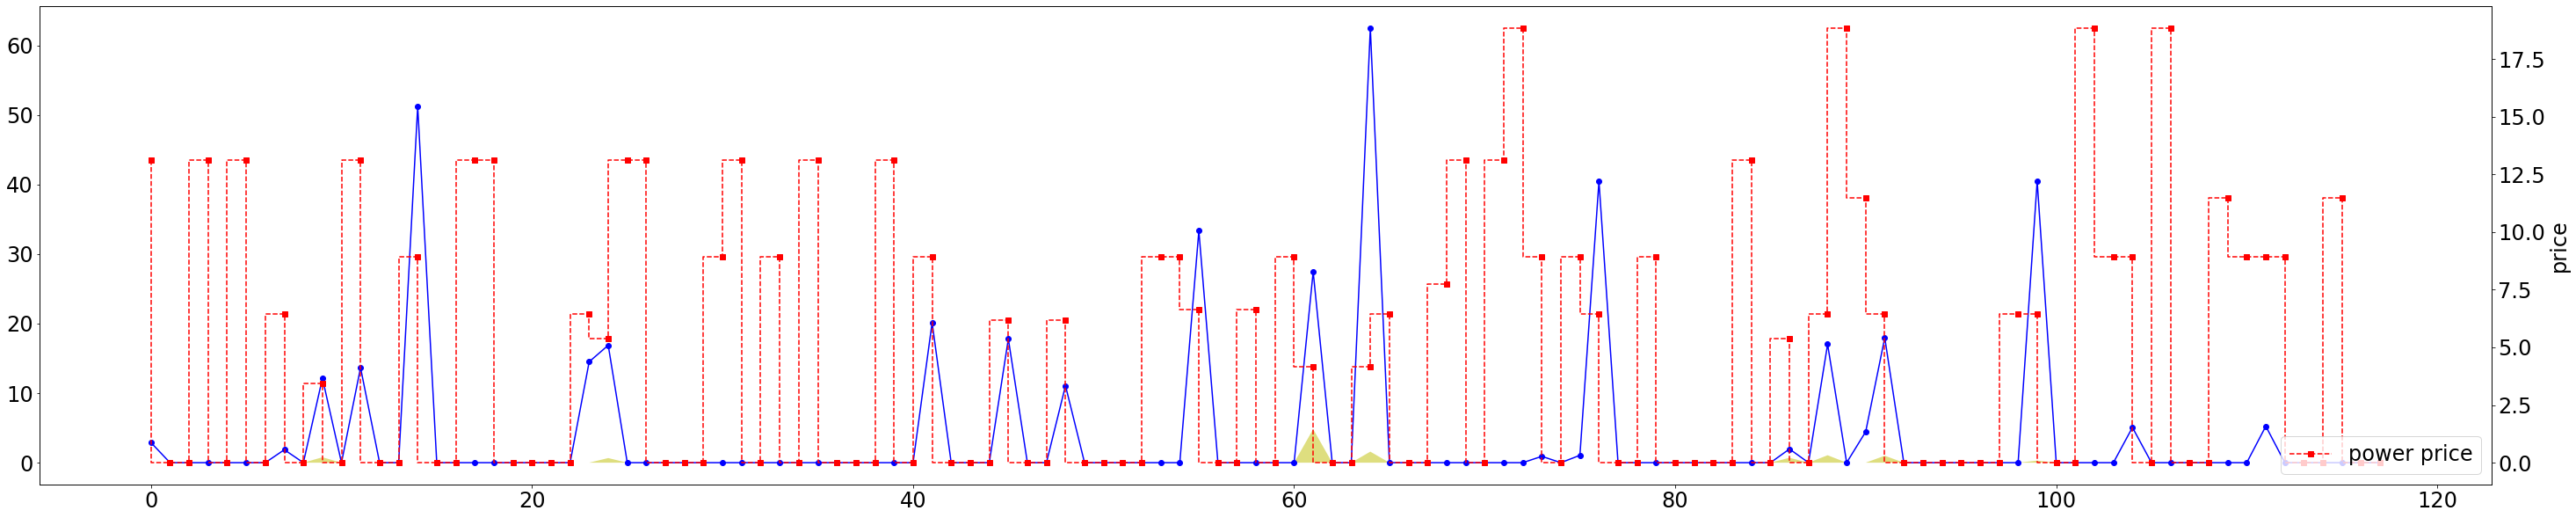

In [ ]:
fsSolns = fsSolns_onPretrain_true

p0_soln = np.array(fsSolns['p0'])
rp_soln = np.array(fsSolns['rp'])
rd_soln = np.array(fsSolns['rd'])

fig, ax = plt.subplots(figsize=(50, 10))
for i in range(p0_soln.shape[0]):
    ax.plot(p0_soln[i, :], 'b-o')
    ax.fill_between(range(numBuses), y1=-rd_soln[i, :], y2=rp_soln[i, :],  facecolor='y', alpha=0.5)

# ax.step(range(numX), busMaxP, 'k-o', markersize=10, linewidth=2, label=r'$P_{max}$')
# ax.set_ylim([0., 150.])

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax1 = ax.twinx()
ax1.step(range(numX), genCost_extension, 'r--s', label='power price')
ax1.legend(fontsize=24, loc='lower right')
ax1.tick_params(axis='y', labelsize=24)
ax1.set_ylabel('price', fontsize=24, rotation=90)

# 1. Solve SA model

In [ ]:
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:50, :]

start_time = time.time()
fsSolns_test_orig = solveTrueModel(inputDemands, numScenarios=100, gamma_res=gammaRes)
print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

json.dump(fsSolns_test_orig, open(savedTrainPath + 'fsSolns_test_orig', 'w'))



Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 2.96 minutes.
Instance: 1 Problem status: optimal 

Evaluation tims for instance 1 is 2.97 minutes.
Instance: 2 Problem status: optimal 

Evaluation tims for instance 2 is 3.19 minutes.
Instance: 3 Problem status: optimal 

Evaluation tims for instance 3 is 3.12 minutes.
Instance: 4 Problem status: optimal 

Evaluation tims for instance 4 is 3.07 minutes.
Instance: 5 Problem status: optimal 

Evaluation tims for instance 5 is 3.30 minutes.
Instance: 6 Problem status: optimal 

Evaluation tims for instance 6 is 3.31 minutes.
Instance: 7 Problem status: optimal 

Evaluation tims for instance 7 is 3.25 minutes.
Instance: 8 Problem status: optimal 

Evaluation tims for instance 8 is 3.50 minutes.
Instance: 9 Problem status: optimal 

Evaluation tims for instance 9 is 3.35 minutes.
Instance: 10 Problem status: optimal 

Evaluation tims for instance 10 is 3.36 minutes.
Instance: 11 Problem status: optimal 

Evaluation ti

In [ ]:
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:1, :]

start_time = time.time()
fsSolns_test_orig_sce300 = solveTrueModel(inputDemands, numScenarios=300, gamma_res=gammaRes)
print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

json.dump(fsSolns_test_orig_sce300, open(savedTrainPath + 'fsSolns_test_orig_sce300', 'w'))



Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 21.79 minutes.
Total solving tims is 22.03 minutes.


In [ ]:
fsSolns_test_orig_sce300 = json.load(open(savedTrainPath + 'fsSolns_test_orig_sce300', 'r')) # 8.65 minutes

# 2. Solve penalty model

In [ ]:
# solve the SAA of penalty model (non-convex) with penalties on generator bounds violation
# and line flow limits violation
def solvePenModel(inputDemands, numScenarios, gamma_res, gamma_gen, gamma_line,
                 delta_gen, delta_line, have_slack=True,
                  useIpopt=True, saveCheckpoints=False, fname=None):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = inputDemands.shape[0]

    all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
    for t in range(numInstance):
        d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
        all_d_omega[:, :, t] = d_omega

    # if caseID == 'wind_penetration':
    # update p_min and p_max if needed

    # calculate sum of demand deviations for each scenario
    # sumMeanDemand = inputDemands.sum(axis=-1)
    # sumMeanDemand2 = np.repeat(sumMeanDemand.reshape(1, -1), numScenarios, axis=0)
    # sumRealTimeDemand = np.sum(all_d_omega, axis=1)
    # sumDemandDeviations = sumRealTimeDemand - sumMeanDemand2

    # Create a solver
    # opt_solver = SolverFactory('ipopt')

    # if used on Google colab
    opt_solver = SolverFactory('ipopt', executable='/content/ipopt')
    # otherwise
    # opt_solver = SolverFactory('ipopt')

    # initialize model
    m = ConcreteModel()

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    scenSet = range(numScenarios)
    busSet = range(numBuses)

    m.busSet = Set(initialize=busSet)
    m.regGenSet = Set(initialize=[x - 1 for x in regGenList])
    m.lineSet = Set(initialize=range(numLines))
    m.scenSet = Set(initialize=scenSet)

    # define data
    demandSum_data = [0.0] * numScenarios
    dev_data = [0.0] * numScenarios

    d_omega_data = dict()
    for u in scenSet:
        for v in busSet:
            d_omega_data[u, v] = 0.

    m.sumMeanDemand = Param(initialize=0., mutable=True)
    m.sumDemandDeviations = Param(m.scenSet, initialize=dev_data, mutable=True)
    m.sumRealTimeDemand = Param(m.scenSet, initialize=demandSum_data, mutable=True)
    m.d_omega = Param(m.scenSet, m.busSet, initialize=d_omega_data, mutable=True)

    # define functions for bounds and objective rules
    def p0_bounds(model, i):
        return busMinP[i], busMaxP[i]

    def r_bounds(model, i):
        return 0, busMaxP[i] - busMinP[i]

    def nonNegativeReals(model, i, j):
        return 0., np.inf

    def alpha_bounds(model, i):
        return 0, np.inf

    # # p bounds
    # def p_bounds(model, i, scen):
    #     return busMinP[i], busMaxP[i]
    #
    # # phase angle bounds
    def theta_bounds(model, i, scen):
        return -theta_max, theta_max

    def obj_rule(model):
        return sum(busCost[i] * model.p_0[i] +
                   busPosResCost[i] * model.rp[i] +
                   busNegResCost[i] * model.rd[i]
                   for i in model.busSet) + \
               (1.0 / numScenarios) * sum(gamma_res * busPosResCost[i] * model.posResViol[i, scen] +
                                          gamma_res * busNegResCost[i] * model.negResViol[i, scen]
                                          for scen in model.scenSet for i in model.busSet) + \
               (1.0 / numScenarios) * sum(gamma_line * model.lineViol[k, scen] ** 2
                                          for scen in model.scenSet for k in model.lineSet) + \
               (1.0 / numScenarios) * sum(gamma_gen * model.genBoundViol[i, scen] ** 2
                                          for scen in model.scenSet for i in model.busSet)
        #    + \
        #     (1.0 / numScenarios) * sum(500. * model.angleBoundViol[i, scen] ** 2
        #                               for scen in model.scenSet for i in model.busSet)

    # first-stage variables
    m.p_0 = Var(m.busSet, bounds=p0_bounds)
    m.rp = Var(m.busSet, bounds=r_bounds)
    m.rd = Var(m.busSet, bounds=r_bounds)
    m.alpha = Var(m.busSet, bounds=alpha_bounds)

    # recourse variables
    # m.p_tilde = Var(m.busSet, m.scenSet, bounds=p_bounds)
    m.p_tilde = Var(m.busSet, m.scenSet)
    m.theta = Var(m.busSet, m.scenSet, bounds=theta_bounds)
    # m.theta = Var(m.busSet, m.scenSet)
    # m.beta = Var(m.busSet, m.scenSet)

    # auxiliary variables
    m.posResViol = Var(m.busSet, m.scenSet, bounds=nonNegativeReals)
    m.negResViol = Var(m.busSet, m.scenSet, bounds=nonNegativeReals)
    m.lineViol = Var(m.lineSet, m.scenSet, bounds=nonNegativeReals)
    m.genBoundViol = Var(m.busSet, m.scenSet, bounds=nonNegativeReals)
    # m.angleBoundViol = Var(m.busSet, m.scenSet, bounds=nonNegativeReals)
    m.s = Var(m.scenSet)

    # objective function
    m.obj = Objective(rule=obj_rule, sense=minimize)

    # first-stage constraints
    def fsConstr1(model):
        return sum(model.p_0[i] for i in m.busSet) == model.sumMeanDemand

    def fsConstr2(model, i):
        return model.p_0[i] + model.rp[i] <= busMaxP[i]

    def fsConstr3(model, i):
        return model.p_0[i] - model.rd[i] >= busMinP[i]

    def fsConstr4(model):
        return sum(model.alpha[i] for i in model.busSet) == 1.

    def fsConstr5(model, i):
        if i not in regGenSet:
            return model.alpha[i] == 0.0
        else:
            return model.alpha[i] <= 1.0

    if fsConstrainID == 'addFSBalance':
        m.fsConstr1 = Constraint(rule=fsConstr1)
    m.fsConstr2 = Constraint(m.busSet, rule=fsConstr2)
    m.fsConstr3 = Constraint(m.busSet, rule=fsConstr3)
    m.fsConstr4 = Constraint(rule=fsConstr4)
    m.fsConstr5 = Constraint(m.busSet, rule=fsConstr5)

    # constraints that define p: affine recourse policy without worrying about generation limits
    def recoursePolicyConstr(model, i, scen):

        if (fsConstrainID is None) and have_slack:
            return model.p_tilde[i, scen] == model.alpha[i] * \
                   (model.sumRealTimeDemand[scen] - sum(model.p_0[n] for n in busSet)) + model.alpha[i] * model.s[scen]

        if (fsConstrainID is None) and not have_slack:
            return model.p_tilde[i, scen] == model.alpha[i] * \
                   (model.sumRealTimeDemand[scen] - sum(model.p_0[n] for n in busSet))

        if fsConstrainID == 'addFSBalance' and have_slack:
            return model.p_tilde[i, scen] == model.alpha[i] * \
                   (model.sumRealTimeDemand[scen] - model.sumMeanDemand) + model.alpha[i] * model.s[scen]

        if fsConstrainID == 'addFSBalance' and not have_slack:
            return model.p_tilde[i, scen] == model.alpha[i] * \
                   (model.sumRealTimeDemand[scen] - model.sumMeanDemand)

    # phase angles
    def phaseAngleConstr(model, scen):

        return model.theta[slackBusNo - 1, scen] == 0.

    # power flow
    def powFlowConstr(model, i, scen):

        return model.p_tilde[i, scen] + model.p_0[i] == sum(
            B[i, k] * model.theta[k, scen] for k in model.busSet) + model.d_omega[scen, i]

    # auxiliary constraints for violations of positive and negative reserves
    def posResViolConstr(model, i, scen):
        return model.posResViol[i, scen] >= model.p_tilde[i, scen] - model.rp[i]

    def negResViolConstr(model, i, scen):
        return model.negResViol[i, scen] >= - model.rd[i] - model.p_tilde[i, scen]

    # auxiliary constraints for line violations
    def lineFlowViolConstr1(model, k, scen):
        return model.lineViol[k, scen] >= sum(F[k, j] * model.theta[j, scen] for j in model.busSet) - \
               delta_line*flow_max[k]

    def lineFlowViolConstr2(model, k, scen):
        return model.lineViol[k, scen] >= -sum(F[k, j] * model.theta[j, scen] for j in model.busSet) - \
               delta_line*flow_max[k]

    # generator bounds violation
    def genBoundViolConstr1(model, i, scen):
        return model.genBoundViol[i, scen] >= (model.p_tilde[i, scen] + model.p_0[i]) - (busMinP[i] +
                                                                                         delta_gen*(busMaxP[i] -
                                                                                                      busMinP[i]))

    def genBoundViolConstr2(model, i, scen):
        return model.genBoundViol[i, scen] >= busMinP[i] + \
               (1-delta_gen)*(busMaxP[i] - busMinP[i]) - (model.p_tilde[i, scen] + model.p_0[i])

    # phase angle bounds violation
    # def angleViolConstr1(model, i, scen):
    #     return model.angleBoundViol[i, scen] >= model.theta[i, scen] - theta_ub

    # def angleViolConstr2(model, i, scen):
    #     return model.angleBoundViol[i, scen] >= - theta_ub - model.theta[i, scen]

    m.rcsConstr0 = Constraint(m.scenSet, rule=phaseAngleConstr)
    m.rcsConstr1 = Constraint(m.busSet, m.scenSet, rule=powFlowConstr)
    m.rcsConstr2 = Constraint(m.busSet, m.scenSet, rule=posResViolConstr)
    m.rcsConstr3 = Constraint(m.busSet, m.scenSet, rule=negResViolConstr)
    m.rcsConstr4 = Constraint(m.lineSet, m.scenSet, rule=lineFlowViolConstr1)
    m.rcsConstr5 = Constraint(m.lineSet, m.scenSet, rule=lineFlowViolConstr2)
    m.rcsConstr6 = Constraint(m.busSet, m.scenSet, rule=genBoundViolConstr1)
    m.rcsConstr7 = Constraint(m.busSet, m.scenSet, rule=genBoundViolConstr2)
    m.rcsConstr8 = Constraint(m.busSet, m.scenSet, rule=recoursePolicyConstr)
    # m.rcsConstr9 = Constraint(m.busSet, m.scenSet, rule=angleViolConstr1)
    # m.rcsConstr10 = Constraint(m.busSet, m.scenSet, rule=angleViolConstr2)

    # *========= CREATE INSTANCE ==========
    pyo_instance = m.create_instance()

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['p0'] = []
    solns['rp'] = []
    solns['rd'] = []
    solns['alpha'] = []
    solns['time'] = []
    solns['prob_lineViol'] = []
    solns['prob_genBoundViol'] = []
    solns['prob_angleBoundViol'] = []

    # *========= PASS INTO DATA AND SOLVE==========
    for t in range(numInstance):
        start_time = time.time()
        predMeanDemand_iter = inputDemands[t, :]
        sumPredMeanDemand_iter = predMeanDemand_iter.sum()
        # print('sumPredMeanDemand_iter:', sumPredMeanDemand_iter.shape)

        pyo_instance.sumMeanDemand = sumPredMeanDemand_iter
        # print(pyo_instance.sumMeanDemand.value)

        d_omega_iter = all_d_omega[:, :, t]
        sumRealTimeDemand_iter = np.sum(d_omega_iter, axis=1)
        # print('sumRealTimeDemand_iter:', sumRealTimeDemand_iter.shape)

        for u in scenSet:
            pyo_instance.sumDemandDeviations[u] = sumRealTimeDemand_iter[u] - sumPredMeanDemand_iter
            pyo_instance.sumRealTimeDemand[u] = sumRealTimeDemand_iter[u]
            for v in busSet:
                pyo_instance.d_omega[u, v] = d_omega_iter[u, v]

        # for scen in scenSet:
        #     print('sumDemandDeviations:', pyo_instance.sumDemandDeviations[scen].value)

        # *========= SOLVE ==========
        # results = SolverFactory('glpk').solve(m)
        results = opt_solver.solve(pyo_instance, tee=False)
        # results.write()
        # if used on Google colab
        # results = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(m)
        solve_status = results.solver.status
        tm_cond = results.solver.termination_condition

        if (solve_status != SolverStatus.ok) or (
                tm_cond not in [TerminationCondition.optimal,
                                TerminationCondition.locallyOptimal,
                                TerminationCondition.globallyOptimal]):
            print("GP model not solved to (sub)optimality using Ipopt!!!")
            print("solve_status: ", solve_status)
            print("termination_condition: ", tm_cond)
            sys.exit(0)
        else:
            print("Instance %d ..." % t)
            print("solve_status: ", solve_status)
            print("termination_condition: ", tm_cond)

        # for scen in scenSet:
        # #     print('\n sumRealTimeDemand-sumMeanDemand:')
        # #     print(pyo_instance.sumRealTimeDemand[scen].value - pyo_instance.sumMeanDemand.value)
        #     print('sumDemandDeviations:')
        #     print(pyo_instance.sumDemandDeviations[scen].value)

        # call pyomo_postprocess if needed

        # solutions per instance
        p0_soln = []
        rp_soln = []
        rd_soln = []
        alpha_soln = []
        for v in pyo_instance.busSet:
            p0_soln += [pyo_instance.p_0[v].value]

            rp_soln += [pyo_instance.rp[v].value]

            rd_soln += [pyo_instance.rd[v].value]

            alpha_soln += [pyo_instance.alpha[v].value]

        solns['estimateTotalCost'] += [pyo_instance.obj()]
        solns['p0'].append(p0_soln)
        solns['rp'].append(rp_soln)
        solns['rd'].append(rd_soln)
        solns['alpha'].append(alpha_soln)

        c_gen = sum(busCost[i] * p0_soln[i]
                    for i in busSet)

        c_res = sum(busPosResCost[i] * rp_soln[i] +
                    busNegResCost[i] * rd_soln[i]
                    for i in busSet)

        c_fs = c_gen + c_res

        c_fs = c_gen + c_res
        c_rcs = pyo_instance.obj() - c_fs
        solns['c_fs'].append(c_fs)
        solns['c_rcs'].append(c_rcs)

        solns['c_gen'].append(c_gen)
        solns['c_res'].append(c_res)

        lineViol_soln = []
        genBoundViol_soln = []
        # angleBoundViol_soln = []
        for k in pyo_instance.lineSet:
            for scen in pyo_instance.scenSet:
                lineViol_soln += [pyo_instance.lineViol[k, scen].value]

        # for n in pyo_instance.busSet:
        #     for scen in pyo_instance.scenSet:
        #         genBoundViol_soln += [pyo_instance.genBoundViol[n, scen].value]
        #         angleBoundViol_soln += [pyo_instance.angleBoundViol[n, scen].value]

        # lineViol_soln = np.array(lineViol_soln)
        # print('lineViol_soln shape:', lineViol_soln.shape)
        # genBoundViol_soln = np.array(genBoundViol_soln)
        # angleBoundViol_soln = np.array(angleBoundViol_soln)

        # count_lineViol = np.where(lineViol_soln > delta_line * flow_max, 1, 0)
        # prob_lineViol = np.sum(count_lineViol) / numLines

        # print('flow_max.shape:', flow_max.shape)

        # print('count_lineViol shape:', count_lineViol.shape)
        # print('count_lineViol:', count_lineViol)
        # print('prob_lineViol:', prob_lineViol)

        # count_genBoundViol = np.where(genBoundViol_soln > delta_gen * busMaxP, 1, 0)
        # prob_genBoundViol = np.sum(count_genBoundViol) / numBuses

        # print('count_genBoundViol shape:', count_genBoundViol.shape)
        # print('count_genBoundViol:', count_genBoundViol)
        # print('prob_genBoundViol:', prob_genBoundViol)

        # count_angleBoundViol = np.where(angleBoundViol_soln > delta_gen * np.pi, 1, 0)
        # prob_angleBoundViol = np.sum(count_angleBoundViol) / numBuses

        # print('count_angleBoundViol shape:', count_angleBoundViol.shape)
        # print('count_angleBoundViol:', count_angleBoundViol)
        # print('prob_angleBoundViol:', prob_angleBoundViol)

        # solns['prob_lineViol'].append(prob_lineViol)
        # solns['prob_genBoundViol'].append(prob_genBoundViol)
        # solns['prob_angleBoundViol'].append(prob_angleBoundViol)

        print('\nSolving tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))
        solns['time'].append(np.round((time.time() - start_time) / 60, 3))

        if saveCheckpoints and (t > 0 and t % 10 == 0):
            json.dump(solns, open(inputDemandPath + fname, 'w'))
    # end of all instances

    return solns

## solutions

In [ ]:
print(delta_line)

0.95


In [ ]:
# X_Test = np.load(inputDemandPath + 'nnTestData.npy')
# inputDemands = X_Test[:10, :]
# numScenarios = 100

# start_time = time.time()
# fsSolns_test_pen_sce300 = solvePenModel(inputDemands, numScenarios, gamma_res=gammaRes, gamma_gen=gammaGen, gamma_line=gammaLine,
#                  delta_gen=delta_gen, delta_line=delta_line, have_slack=True,
#                  useIpopt=True, saveCheckpoints=False, fname=None)

# print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

# json.dump(fsSolns_test_pen_sce300, open(savedTrainPath + 'fsSolns_test_pen_10inst_100scen', 'w'))
# # 52.04 minutes

Instance 0 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 0 is 43.74 minutes.
Instance 1 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 1 is 36.55 minutes.
Instance 2 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 2 is 33.24 minutes.
Instance 3 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 3 is 21.17 minutes.
Instance 4 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 4 is 24.11 minutes.
Instance 5 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 5 is 32.88 minutes.
Instance 6 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 6 is 27.61 minutes.
Instance 7 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 7 is 28.48 minutes.
Instance 8 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 8 is 30.09 m

In [ ]:
# X_Test = np.load(inputDemandPath + 'nnTestData.npy')
# inputDemands = X_Test[:10, :]

inputDemands = predMeanDemand.reshape(1,-1)
numScenarios = 100

start_time = time.time()
penalty_nominal_ipopt_K100_1000pp = solvePenModel(inputDemands, numScenarios, gamma_res=gammaRes,
                                           gamma_gen=gammaGen, gamma_line=gammaLine,
                 delta_gen=delta_gen, delta_line=delta_line)

print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_onTestSet_byP', 'w'))
# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_test_pen_10inst_100sce', 'w'))
json.dump(penalty_nominal_ipopt_K100_1000pp, open(savedTrainPath + 'penalty_nominal_ipopt_K100_1000pp', 'w'))

# fsSolns_onTestSet_byP = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byP', 'r'))

# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_test_pen_100scen', 'w')) # cost 24.88 minutes

Instance 0 ...
solve_status:  ok
termination_condition:  optimal

Solving tims for instance 0 is 74.27 minutes.
Total solving tims is 86.64 minutes.


In [ ]:
alpha_soln = np.array(penalty_nominal_ipopt_K100_1000pp['alpha']).T
alpha_soln.shape

(118, 1)

# test penalty method

In [ ]:
# true_model.py
# TRUE MODEL SOLVED BY COMMERCIAL SOLVER GLPK BUILT IN PYOMO

import numpy as np
import cvxpy as cp
import sys

# from mod118bus import *
# from utilities import *
# from params import *


# solve the true SAA model (large-scale LP)
def testPenaltyMethod(inputDemands, numScenarios, alphaSoln,
                   gamma_res, gamma_line,
                   saveCheckpoints=False, fname=None):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = inputDemands.shape[0]
    print('alphaSoln:', alphaSoln.shape)

    all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
    for t in range(numInstance):
        d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
        all_d_omega[:, :, t] = d_omega

    all_sumD = np.sum(all_d_omega, axis=1)


    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(numBuses)
    scenSet = range(numScenarios)
    lineSet = range(numLines)

    busMaxP_copy = busMaxP.reshape(-1, 1)
    busMinP_copy = busMinP.reshape(-1, 1)
    flow_max_copy = flow_max.reshape(-1, 1)

    # dictionary to store results for all instances
    solns = dict()
    solns['estimateTotalCost'] = []
    solns['c_gen'] = []
    solns['c_res'] = []
    solns['c_fs'] = []
    solns['c_rcs'] = []
    solns['p0'] = []
    solns['rp'] = []
    solns['rd'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T

        sumD = all_sumD[:, t].reshape(1,-1)

        # first-stage variables
        p_0 = cp.Variable(shape=(numBuses, 1), name='p0')
        rp = cp.Variable(shape=(numBuses, 1), name='rp')
        rd = cp.Variable(shape=(numBuses, 1), name='rd')

        # recourse variables
        p_tilde = cp.Variable(shape=(numBuses, numScenarios), name='p')
        theta = cp.Variable(shape=(numBuses, numScenarios), name='theta')
        s = cp.Variable(shape=(1, numScenarios), name='slack')

        constraints = [
                        # cp.sum(p_0) == np.sum(inputDemands[t, :]),
                       p_0 <= busMaxP_copy,
                       p_0 >= busMinP_copy,
                       p_0 + rp <= busMaxP_copy,
                       p_0 - rd >= busMinP_copy,
                       rp >= np.zeros_like(rp),
                       rd >= np.zeros_like(rd),
                       theta <= theta_max * np.ones_like(theta),
                       theta >= -theta_max * np.ones_like(theta),
                       theta[slackBusNo - 1, :] == np.zeros(numScenarios),
                    #    p_0 + p_tilde <= np.repeat(busMaxP_copy, numScenarios, axis=1),
                    #    p_0 + p_tilde >= np.repeat(busMinP_copy, numScenarios, axis=1),
                    #    F @ theta <= np.repeat(flow_max_copy, numScenarios, axis=1),
                    #    F @ theta >= -np.repeat(flow_max_copy, numScenarios, axis=1),
                       p_0 + p_tilde == B @ theta + d_omega,
                       p_tilde == alphaSoln@ (sumD - cp.sum(p_0)) + alphaSoln @ s
                       ]

        # if fsConstrainID == 'addFSBalance':
        #     constraints += [cp.sum(p_0) == np.sum(inputDemands[t, :])]

        c_gen = sum(busCost[i] * p_0[i]
                   for i in busSet)

        c_res = sum(busPosResCost[i] * rp[i] + busNegResCost[i] * rd[i]
                   for i in busSet)

        c_fs = c_gen + c_res

        c_rcs = (1.0 / numScenarios) * sum(
            gamma_res * busPosResCost[i] * cp.maximum(p_tilde[i, scen] - rp[i], 0.0) +
            gamma_res * busNegResCost[i] * cp.maximum(- rd[i] - p_tilde[i, scen], 0.0)
            for scen in scenSet for i in busSet) +\
            (1.0 / numScenarios) * gamma_line * cp.sum_squares(
            cp.maximum(F @ theta - np.repeat(flow_max_copy, numScenarios, axis=1), 0.0)  +
            cp.maximum(-np.repeat(flow_max_copy, numScenarios, axis=1) - F @ theta, 0.0) )
            # +\
            # (1.0 / numScenarios) * 100 * cp.sum_squares(
            # cp.maximum(theta - theta_max * np.ones_like(theta), 0.0)  +
            # cp.maximum(-theta_max * np.ones_like(theta) - theta, 0.0) )

            #    F @ theta - np.repeat(flow_max_copy, numScenarios, axis=1),
                    #    F @ theta >= -np.repeat(flow_max_copy, numScenarios, axis=1) - F @ theta,


                    #    theta - theta_max * np.ones_like(theta),
                    #    theta >= -theta_max * np.ones_like(theta) - theta,


        problem = cp.Problem(cp.Minimize(c_fs + c_rcs), constraints)

        try:
            problem.solve(solver=cp.ECOS)
        except:
            problem.solve(solver=cp.CVXOPT)
            # solns['estimateTotalCost'] += [np.inf]
            # solns['c_gen'] += [np.inf]
            # solns['c_res'] += [np.inf]
            # solns['c_fs'] += [np.inf]
            # solns['c_rcs'] += [np.inf]
            # solns['p0'] += [np.inf]
            # solns['rp'] += [np.inf]
            # solns['rd'] += [np.inf]
            # continue

        # problem.solve(solver=cp.CVXOPT)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)
            # sys.exit(0)
            solns['estimateTotalCost'] += [-np.inf]
            solns['c_gen'] += [-np.inf]
            solns['c_res'] += [-np.inf]
            solns['c_fs'] += [-np.inf]
            solns['c_rcs'] += [-np.inf]
            solns['p0'] += [-np.inf]
            solns['rp'] += [-np.inf]
            solns['rd'] += [-np.inf]
            continue

        print("Instance: %d Problem status: %s " % (t, problem.status))

        solns['estimateTotalCost'] += [c_fs.value.item() + c_rcs.value.item()]
        solns['c_gen'] += [c_gen.value.item()]
        solns['c_res'] += [c_res.value.item()]
        solns['c_fs'] += [c_fs.value.item()]
        solns['c_rcs'] += [c_rcs.value.item()]
        solns['p0'] += [list(p_0.value[:,0])]
        solns['rp'] += [list(rp.value[:,0])]
        solns['rd'] += [list(rd.value[:,0])]

        print('\nEvaluation tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

    return solns


In [ ]:
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:1, :]

# inputDemands = predMeanDemand.reshape(1,-1)
numScenarios = 100

start_time = time.time()
penalty_test_ipopt_K100_pp1000 = testPenaltyMethod(inputDemands, numScenarios, alpha_soln,
                        gamma_res=gammaRes, gamma_line=gammaLine,
                        saveCheckpoints=False, fname=None)

print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_onTestSet_byP', 'w'))
# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_test_pen_10inst_100sce', 'w'))
json.dump(penalty_test_ipopt_K100_pp1000, open(savedTrainPath + 'penalty_test_ipopt_K100_pp1000', 'w'))

# fsSolns_onTestSet_byP = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byP', 'r'))

# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_test_pen_100scen', 'w')) # cost 24.88 minutes

alphaSoln: (118, 1)


In [ ]:
penalty_test_ipopt_K100_pp1000.keys()

dict_keys(['estimateTotalCost', 'c_gen', 'c_res', 'c_fs', 'c_rcs', 'p0', 'rp', 'rd'])

In [ ]:
penalty_test_ipopt_K100_pp1000['estimateTotalCost']

[inf]

In [ ]:
# fsSolns_onTestSet_byP = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byP', 'r'))

In [ ]:
# json.dump(fsSolns_onTestSet_byP, open(savedTrainPath + 'fsSolns_test_gen_sce100', 'w'))

# 3. Solve recourse problem

In [ ]:
import cvxpy as cp
def solveRecourse(inputDemands, all_d_omega, p0_soln, rp_soln, rd_soln,
                  fsCost, gamma_res, return_rcsSolns=False):
    # *====== CONSTRUCT SCENARIOS FOR EACH INSTANCE =======
    numInstance = inputDemands.shape[0]
    numScenarios = all_d_omega.shape[0]

    # all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
    # for t in range(numInstance):
    #     d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
    #     all_d_omega[:, :, t] = d_omega

    # dictionary to store recourse solutions in case return_rcsSolns is true
    rcsSolns = dict()
    rcsSolns['d_omega'] = np.zeros((numBuses, numInstance))
    rcsSolns['theta'] = []
    rcsSolns['p_tilde'] = []
    if return_rcsSolns:
        # there will only be a single scenario for each instance under this setting
        rcsSolns['d_omega'] = all_d_omega[0, :, :]

    # define sets and indexes
    # to be compatible with numpy data indexes, use Set() and initialize with numpy range
    busSet = range(numBuses)
    scenSet = range(numScenarios)

    busMaxP_copy = busMaxP.reshape(-1, 1)
    busMinP_copy = busMinP.reshape(-1, 1)
    flow_max_copy = flow_max.reshape(-1, 1)

    # dictionary to store results for all instances
    evalSolns = dict()
    evalSolns['Status'] = []
    evalSolns['fsCost'] = []
    evalSolns['rcsCost'] = []
    evalSolns['evaluateTotalCost'] = []

    for t in range(numInstance):
        start_time = time.time()

        # *====== FOR EACH INSTANCE =======
        d_omega = all_d_omega[:, :, t].T
        # print('d_omega:', d_omega.shape)

        # recourse variables
        p_tilde = cp.Variable(shape=(numBuses, numScenarios), name='p')
        theta = cp.Variable(shape=(numBuses, numScenarios), name='theta')

        constraints = [
                       theta <= theta_max *np.ones_like(theta),
                       theta >= -theta_max *np.ones_like(theta),
                       theta[slackBusNo - 1, :] == np.zeros(numScenarios),
                       p0_soln[t:t+1, :].T + p_tilde <= np.repeat(busMaxP_copy, numScenarios, axis=1),
                       p0_soln[t:t+1, :].T + p_tilde >= np.repeat(busMinP_copy, numScenarios, axis=1),
                       F @ theta <= np.repeat(flow_max_copy, numScenarios, axis=1),
                       F @ theta >= -np.repeat(flow_max_copy, numScenarios, axis=1),
                       p0_soln[t:t+1, :].T + p_tilde  == B @ theta + d_omega
                       ]

        # print('busPosResCost:', busPosResCost.shape)
        # print('p_tilde:', p_tilde.shape)
        # print('p0_soln:', p0_soln.shape)

        cost = (1.0 / numScenarios) * sum(
            gamma_res * busPosResCost[i] * cp.maximum(p_tilde[i, scen] - rp_soln[t, i], 0.0) +
            gamma_res * busNegResCost[i] * cp.maximum(- rd_soln[t, i] - p_tilde[i, scen], 0.0)
            for scen in scenSet for i in busSet)

        problem = cp.Problem(cp.Minimize(cost), constraints)

        problem.solve(solver=cp.ECOS)

        # if problem.status not in ["infeasible", "unbounded"]:
        #     # Otherwise, problem.value is inf or -inf, respectively.
        #     print("Optimal value: %s" % problem.value)
        #     for variable in problem.variables():
        #         print("Variable %s: value %s" % (variable.name(), variable.value))

        if problem.status in ["infeasible", "unbounded"]:
            print("Model not solved to (sub)optimality using CVXPY!!!")
            print("solve_status: ", problem.status)

            evalSolns['Status'] += [str(problem.status)]
            evalSolns['fsCost'] += [fsCost[t]]
            evalSolns['rcsCost'] += [np.inf]
            evalSolns['evaluateTotalCost'] += [np.inf]

            if return_rcsSolns:
                rcsSolns['theta'].append([np.inf]*numBuses)
                rcsSolns['p_tilde'].append([np.inf]*numBuses)

            # sys.exit(0)
            continue

        print("Instance: %d Problem status: %s " % (t, problem.status))

        evalSolns['Status'] += [str(problem.status)]
        evalSolns['fsCost'] += [fsCost[t]]
        evalSolns['rcsCost'] += [cost.value.item()]
        evalSolns['evaluateTotalCost'] += [fsCost[t] + cost.value.item()]

        if return_rcsSolns:
            rcsSolns['theta'].append(list(theta.value[:, 0]))
            rcsSolns['p_tilde'].append(list(p_tilde.value[:, 0]))

        print('\nEvaluation tims for instance %d is %.2f minutes.' % (t, (time.time() - start_time) / 60))

    return evalSolns, rcsSolns

In [ ]:
def evalPenaltyModel(inputDemands, all_d_omega, fsSolns, alpha):
    numInstances = inputDemands.shape[0]

    full_p0_soln = np.array(fsSolns['p0'][:numInstances])
    full_rp_soln = np.array(fsSolns['rp'][:numInstances])
    full_rd_soln = np.array(fsSolns['rd'][:numInstances])
    if alpha:
        full_alpha_soln = np.array(fsSolns['alpha'][:numInstances])
        # print('full_alpha_soln:', full_alpha_soln.shape)
    # print('full_p0_soln:', full_p0_soln.shape)
    # print('full_rp_soln:', full_rp_soln.shape)
    # print('full_rd_soln:', full_rd_soln.shape)


    # p0_soln = full_p0_soln[:, regGenSet]
    # rp_soln = full_rp_soln[:, regGenSet]
    # rd_soln = full_rd_soln[:, regGenSet]
    # if alpha:
    #     alpha_soln = full_alpha_soln[:, regGenSet]
    #     print('alpha_soln:', alpha_soln.shape)
    # print('p0_soln:', p0_soln.shape)
    # print('rp_soln:', rp_soln.shape)
    # print('rd_soln:', rd_soln.shape)


    # c_fs2 = []
    # for t in range(p0_soln.shape[0]):
    #     c_fs2.append(sum(busCost[i] * p0_soln[t, i] + busPosResCost[i] * rp_soln[t, i] + busNegResCost[i] * rd_soln[t, i]
    #                     for i in range(numRegGen)))

    # fsSolns['c_fs2'] = c_fs2

    c_fs = fsSolns['c_fs'][:numInstances]
    print('c_fs:', c_fs)

    start_time = time.time()
    evalSolns, rcsSolns = solveRecourse(inputDemands, all_d_omega, p0_soln=full_p0_soln, rp_soln=full_rp_soln, rd_soln=full_rd_soln,
                    fsCost=c_fs, gamma_res=gammaRes, return_rcsSolns=True)

    print('Total solving tims is %.2f minutes.' % ((time.time() - start_time) / 60))

    # json.dump(evalSolns, open(summaryPath + fname, 'w'))

    return evalSolns, rcsSolns

## generate scenario

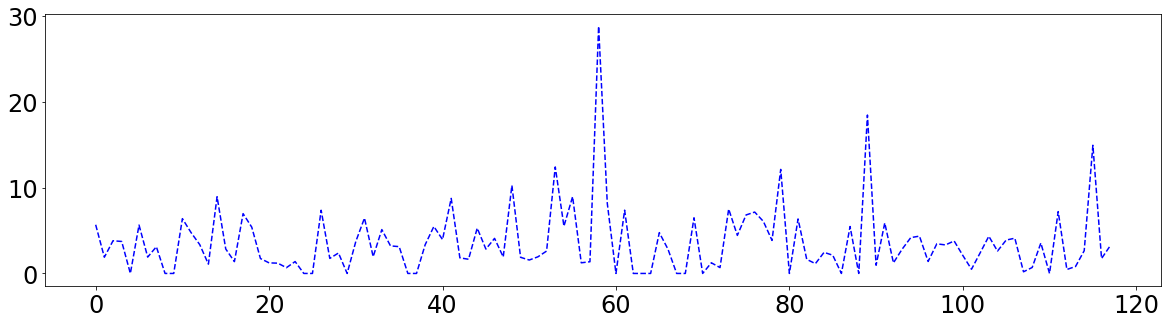

In [ ]:
# X_Test = np.load(inputDemandPath + 'nnTestData.npy')
# inputDemands = X_Test[:1, :]

# numInstance = inputDemands.shape[0]
# numScenarios = 1
# all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
# for t in range(numInstance):
#     d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
#     all_d_omega[:, :, t] = d_omega

# np.save(savedTrainPath + 'all_d_omega.npy', all_d_omega)

# # all_d_omega = np.load(savedTrainPath + 'all_d_omega.npy')

# fig, ax = plt.subplots(figsize=(20, 5))
# ax.plot(all_d_omega[0, :, 0], 'b--')
# ax.tick_params(axis='x', labelsize=24)
# ax.tick_params(axis='y', labelsize=24)
# plt.show()

In [ ]:
fsSolns_onTestSet_byP = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byP', 'r'))
fsSolns_onTestSet_byTrue = json.load(open(savedTrainPath + 'fsSolns_test_orig', 'r'))

In [ ]:
# fsSolns_onTestSet_byNN = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byNN', 'r'))

In [ ]:
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:10, :]

numInstance = inputDemands.shape[0]
numScenarios = 100

common_test_scenarios_K100 = np.load(savedTrainPath + 'common_test_scenarios_K100.npy')

evalSolns_P,  rcsSolns_P = evalPenaltyModel(inputDemands, common_test_scenarios_K100, penalty_nominal_ipopt_K100_1000pp, alpha=True)
# evalSolns_true,  rcsSolns_true = evalPenaltyModel(inputDemands, all_d_omega, fsSolns_onTestSet_byTrue, alpha=False)


json.dump(evalSolns_P, open(savedTrainPath + 'penalty_method_eval_K100_1000pp', 'w'))
np.save(savedTrainPath + 'penalty_method_rcs_solns_K100_1000pp.npy', rcsSolns_P)

c_fs: [6172.730902957841]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 2.39 minutes.


ValueError: ignored

In [ ]:
print(fsSolns_onTestSet_byP['c_gen'])
print(fsSolns_onTestSet_byP['c_res'])
print(evalSolns_P['fsCost'])
print(evalSolns_P['rcsCost'])
print(evalSolns_P['evaluateTotalCost'])

[4974.862916806261]
[1425.666184617654]
[6400.529101423915]
[716.0678463469138]
[7116.596947770829]


In [ ]:
print(fsSolns_onTestSet_byTrue['c_gen'])
print(fsSolns_onTestSet_byTrue['c_res'])
print(evalSolns_true['fsCost'])
print(evalSolns_true['rcsCost'])
print(evalSolns_true['evaluateTotalCost'])

[2797.0119722468457]
[85.62447110542783]
[2882.636443352277]
[8.314054019275228e-08]
[2882.6364434354177]


## test over 1000 scenarios

In [ ]:
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:1, :]


numInstance = inputDemands.shape[0]
numScenarios = 10
all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
all_d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
print('all_d_omega:', all_d_omega.shape)

np.save(savedTrainPath + 'all_d_omega.npy', all_d_omega)

all_d_omega = np.load(savedTrainPath + 'all_d_omega.npy')

all_d_omega: (10, 118)


In [ ]:
eval_solns_pModel = {'c_fs': [], 'c_rcs': [], 'c_total': []}
eval_solns_saModel = {'c_fs': [], 'c_rcs': [], 'c_total': []}
for i in range(numScenarios):
    d_omega = all_d_omega[i, :].reshape(1, numBuses, 1)
    print('d_omega:', d_omega.shape)

    evalSolns_P,  _ = evalPenaltyModel(inputDemands, d_omega, fsSolns_onTestSet_byP, alpha=True)
    evalSolns_true,  _ = evalPenaltyModel(inputDemands, d_omega, fsSolns_onTestSet_byTrue, alpha=False)

    eval_solns_pModel['c_fs'].append(evalSolns_P['fsCost'][0])
    eval_solns_pModel['c_rcs'].append(evalSolns_P['rcsCost'][0])
    eval_solns_pModel['c_total'].append(evalSolns_P['evaluateTotalCost'][0])

    eval_solns_saModel['c_fs'].append(evalSolns_true['fsCost'][0])
    eval_solns_saModel['c_rcs'].append(evalSolns_true['rcsCost'][0])
    eval_solns_saModel['c_total'].append(evalSolns_true['evaluateTotalCost'][0])

# json.dump(eval_solns_pModel, open(savedTrainPath + 'eval_solns_pModel', 'w'))
# json.dump(eval_solns_saModel, open(savedTrainPath + 'eval_solns_saModel', 'w'))

# eval_solns_pModel = json.load(open(savedTrainPath + 'eval_solns_pModel', 'r'))
# eval_solns_saModel = json.load(open(savedTrainPath + 'eval_solns_saModel', 'r'))

d_omega: (1, 118, 1)
c_fs: [5577.7285919163]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
c_fs: [2887.9901190351616]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
d_omega: (1, 118, 1)
c_fs: [5577.7285919163]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
c_fs: [2887.9901190351616]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
d_omega: (1, 118, 1)
c_fs: [5577.7285919163]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
c_fs: [2887.9901190351616]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Total solving tims is 0.01 minutes.
d_omega: (1, 118, 1)
c_fs: [5577.7285919163]
Instanc

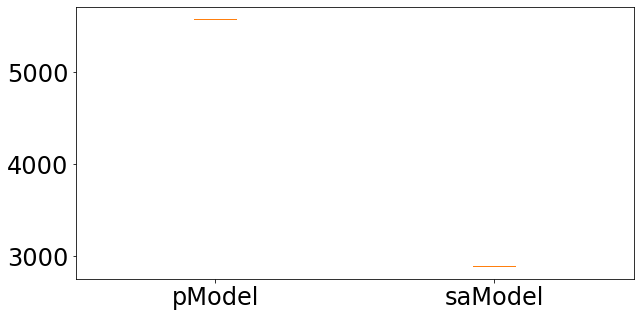

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
data = [eval_solns_pModel['c_fs'], eval_solns_saModel['c_fs']]

ax.boxplot(data, sym='g+', labels=['pModel', 'saModel'])

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
# ax.set_ylim([350., 400.])
plt.show()

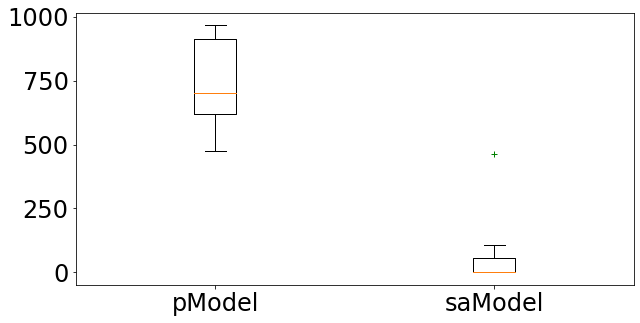

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
data = [eval_solns_pModel['c_rcs'], eval_solns_saModel['c_rcs']]

ax.boxplot(data, sym='g+', labels=['pModel', 'saModel'])

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
# ax.set_ylim([350., 400.])
plt.show()

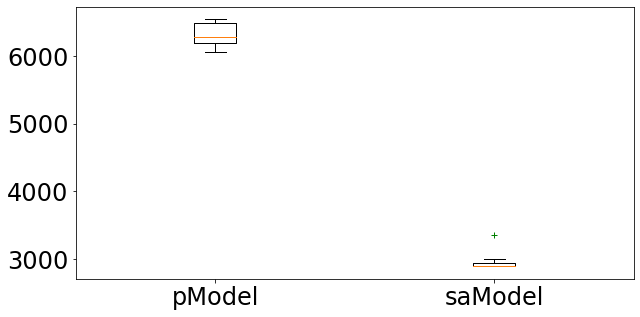

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
data = [eval_solns_pModel['c_total'], eval_solns_saModel['c_total']]

ax.boxplot(data, sym='g+', labels=['pModel', 'saModel'])

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
# ax.set_ylim([350., 400.])
plt.show()

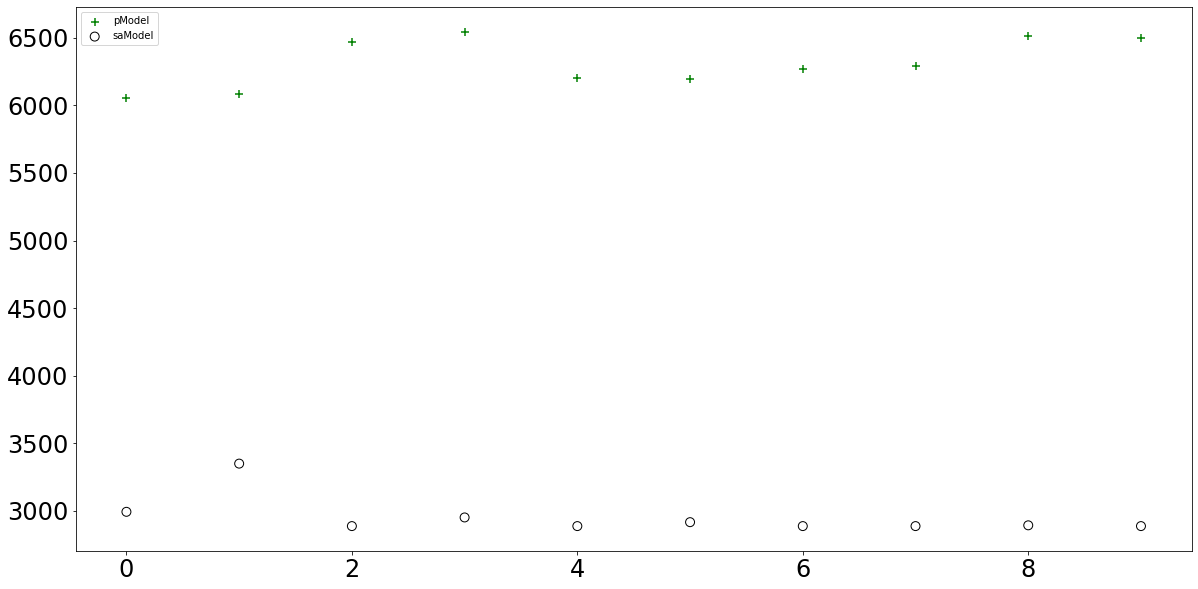

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
# data = [eval_solns_pModel['c_total'], eval_solns_saModel['c_total']]

ax.scatter(range(numScenarios), eval_solns_pModel['c_total'], s=80, color='g', marker='+', label='pModel')
ax.scatter(range(numScenarios), eval_solns_saModel['c_total'], s=80, facecolors='none', edgecolors='k', label='saModel')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
# ax.set_ylim([350., 400.])
ax.legend()
plt.show()

In [ ]:
sum(eval_solns_pModel['c_total']) / numScenarios

6312.217352207628

In [ ]:
sum(eval_solns_saModel['c_total']) / numScenarios

2954.642645003442

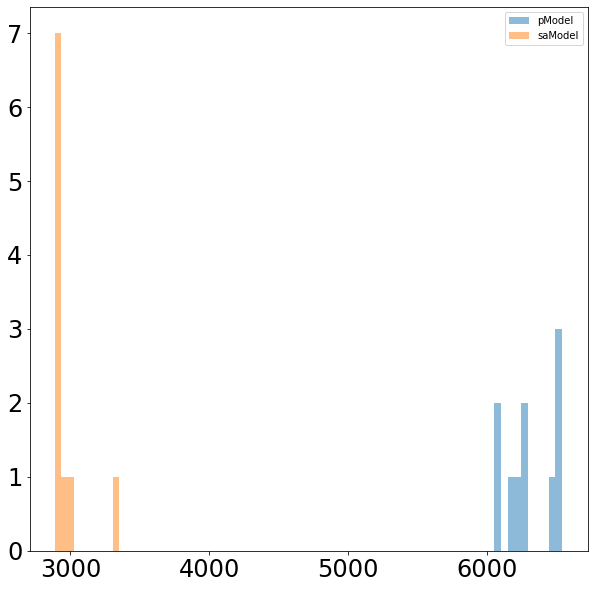

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# data = [eval_solns_pModel['c_total'], eval_solns_saModel['c_total']]

ax.hist(eval_solns_pModel['c_total'], label='pModel', alpha=0.5)
ax.hist(eval_solns_saModel['c_total'], label='saModel', alpha=0.5)


ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
# ax.set_ylim([350., 400.])
ax.legend()
plt.show()

# plot fs solns

In [ ]:
def get_fs_solns(inputDemands, fsSolns, alpha):
    numInstances = inputDemands.shape[0]

    full_p0_soln = np.array(fsSolns['p0'][:numInstances])
    full_rp_soln = np.array(fsSolns['rp'][:numInstances])
    full_rd_soln = np.array(fsSolns['rd'][:numInstances])
    if alpha:
        full_alpha_soln = np.array(fsSolns['alpha'][:numInstances])
        print('full_alpha_soln:', full_alpha_soln.shape)
    print('full_p0_soln:', full_p0_soln.shape)
    print('full_rp_soln:', full_rp_soln.shape)
    print('full_rd_soln:', full_rd_soln.shape)

    if alpha:
        return full_p0_soln, full_rp_soln, full_rd_soln, full_alpha_soln
    return full_p0_soln, full_rp_soln, full_rd_soln

In [ ]:
p0_true, rp_true, rd_true = get_fs_solns(inputDemands, fsSolns_onTestSet_byTrue, alpha=False)
p0_P, rp_P, rd_P, alpha_P = get_fs_solns(inputDemands, fsSolns_onTestSet_byP, alpha=True)

full_p0_soln: (1, 118)
full_rp_soln: (1, 118)
full_rd_soln: (1, 118)
full_alpha_soln: (1, 118)
full_p0_soln: (1, 118)
full_rp_soln: (1, 118)
full_rd_soln: (1, 118)


In [ ]:
# p0_nn, rp_nn, rd_nn = get_fs_solns(inputDemands, fsSolns_onTestSet_byNN, alpha=False)

full_p0_soln: (1, 118)
full_rp_soln: (1, 118)
full_rd_soln: (1, 118)


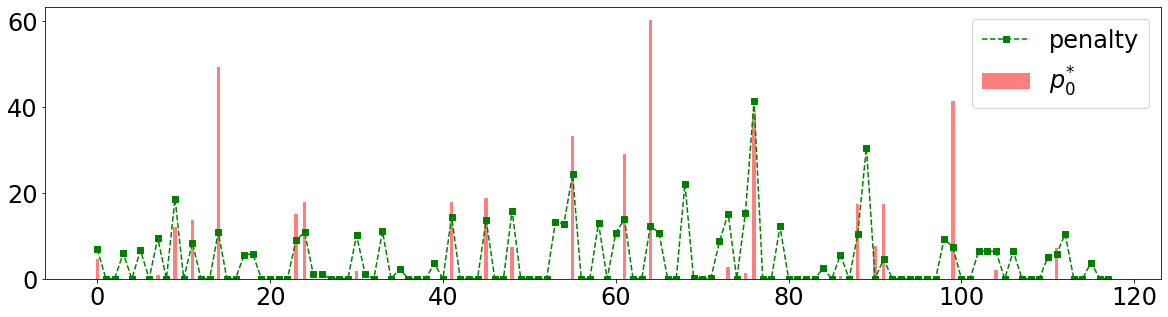

418.7693731030865
520.1037741702613


In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(range(numBuses), p0_true[0, :], width=0.4, alpha=0.5, color='r', label=r'$p_0^{*}$')
ax.plot(p0_P[0, :], 'g--s', label='penalty')
# ax.plot(p0_nn[0, :], 'b--o', label='nn')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.legend(fontsize=24)
plt.show()

print(sum(p0_true[0, :]))
print(sum(p0_P[0, :]))

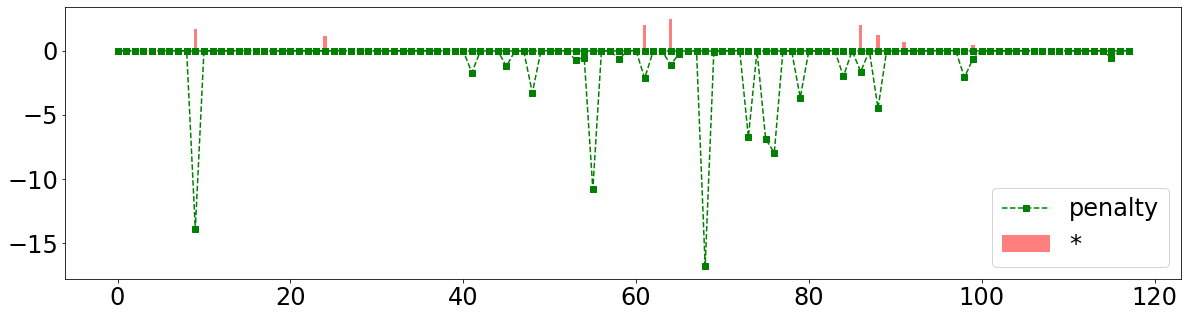

2.0140472338333573e-05
90.00217794895445
11.725214866930267
-3.884652050073275e-11


In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.bar(range(numBuses), rp_true[0, :], width=0.4, alpha=0.5, color='r', label='*')
ax.bar(range(numBuses), -rd_true[0, :], width=0.4, alpha=0.5, color='r')
ax.plot(rp_P[0, :], 'g--s', label='penalty')
ax.plot(-rd_P[0, :], 'g--s')
# ax.plot(rp_nn[0, :], 'b--o', label='nn')
# ax.plot(-rd_nn[0, :], 'b--o')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.legend(fontsize=24)
plt.show()

print(sum(rp_P[0, :]))
print(sum(rd_P[0, :]))
print(sum(rp_true[0, :]))
print(sum(rd_true[0, :]))

# Pretrain data

In [ ]:
inputDemands = nnPreTrainData[:10, :]

# fsSolns = solveTrueModel(nnPreTrainData, numScenarios=200, gamma_res=10., useGurobi=False)
fsSolns = fsSolns_onPretrain_true

p0Data = np.array(fsSolns['p0'])
rpData = np.array(fsSolns['rp'])
rdData = np.array(fsSolns['rd'])
print('p0Data:', p0Data.shape)
print('rpData:', rpData.shape)
print('rdData:', rdData.shape)

allX = inputDemands
allY = np.concatenate([p0Data, rpData, rdData], axis=-1)

numScenarios = 1
numInstance = allX.shape[0]
all_d_omega = np.zeros((numScenarios, numBuses, numInstance))
for t in range(numInstance):
    d_omega, _ = generateRealTimeScenarios(inputDemands[t, :], numBuses, zeroLoads, numScenarios, inputDemandPath)
    all_d_omega[:, :, t] = d_omega

# np.save(savedTrainPath + 'all_d_omega.npy', all_d_omega)

evalSolns,  rcsSolns = evalPenaltyModel(inputDemands, all_d_omega, fsSolns_onPretrain_true, alpha=False)

d_omegaData = rcsSolns['d_omega'].T
thetaData = np.array(rcsSolns['theta'])
p_tildeData = np.array(rcsSolns['p_tilde'])

X_preTrain = np.concatenate([allX, allY], axis=-1)
X_preTrain2 = np.concatenate([d_omegaData, p0Data, rpData, rdData, thetaData, p_tildeData], axis=-1)

np.save(inputDemandPath + 'X_preTrain.npy', X_preTrain)
np.save(inputDemandPath + 'X_preTrain2.npy', X_preTrain2)

p0Data: (10, 118)
rpData: (10, 118)
rdData: (10, 118)
c_fs: [2861.868921414564, 2968.7101123852863, 2860.250081625095, 2855.8580176000673, 2773.4818323540326, 2993.2020662562018, 2889.6524380220994, 2929.9524229625245, 2835.58417826202, 2829.4101417067664]
Instance: 0 Problem status: optimal 

Evaluation tims for instance 0 is 0.01 minutes.
Instance: 1 Problem status: optimal 

Evaluation tims for instance 1 is 0.01 minutes.
Instance: 2 Problem status: optimal 

Evaluation tims for instance 2 is 0.01 minutes.
Instance: 3 Problem status: optimal 

Evaluation tims for instance 3 is 0.01 minutes.
Instance: 4 Problem status: optimal 

Evaluation tims for instance 4 is 0.01 minutes.
Instance: 5 Problem status: optimal 

Evaluation tims for instance 5 is 0.01 minutes.
Instance: 6 Problem status: optimal 

Evaluation tims for instance 6 is 0.01 minutes.
Instance: 7 Problem status: optimal 

Evaluation tims for instance 7 is 0.01 minutes.
Instance: 8 Problem status: optimal 

Evaluation tims f

## line flow

In [ ]:
# define useful sets and matrices
nonSlackSet = list(range(1, slackBusNo)) + list(range(slackBusNo + 1, numBuses + 1))
nonSlackSet2 = [x-1 for x in nonSlackSet]

oneN = np.ones((numRegGen, 1))
zeroN = np.zeros((numRegGen, 1))
nullN = np.zeros((numRegGen, numRegGen))
eyeN = np.eye(numRegGen)

modF = np.take(F, nonSlackSet2, axis=-1)
modB = np.take(B, nonSlackSet2, axis=-1)

modB_over_nonslack = np.take(modB, nonSlackSet2, axis=0)
modBInverse = np.linalg.inv(modB_over_nonslack)
modB_over_gen = np.take(modB, regGenSet, axis=0)
b_slack = modB[slackBusNo-1:slackBusNo, :]

flows = F @ thetaData.T
flows.shape

(186, 10)

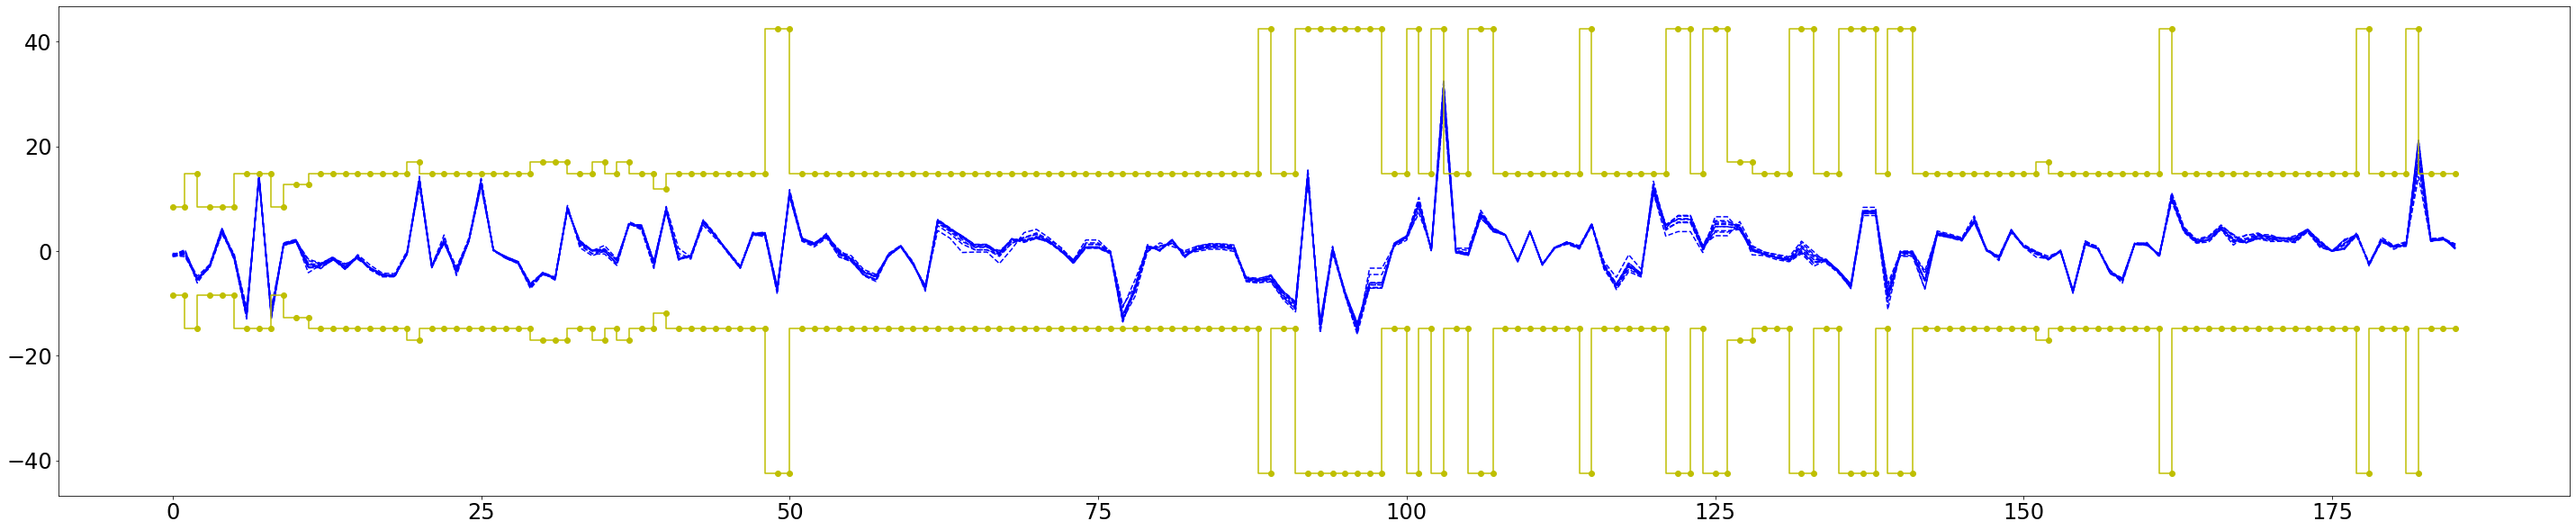

In [ ]:
fig, ax = plt.subplots(figsize=(50, 10))
for i in range(flows.shape[1]):
    ax.plot(range(flows.shape[0]), flows[:, i], 'b--')
ax.step(range(flows.shape[0]), flow_max, 'y-o')
ax.step(range(flows.shape[0]), -flow_max, 'y-o')
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

## recourse solutions

In [ ]:
display_rcsSolns(d_omegaData, p0Data, p_tildeData, thetaData)

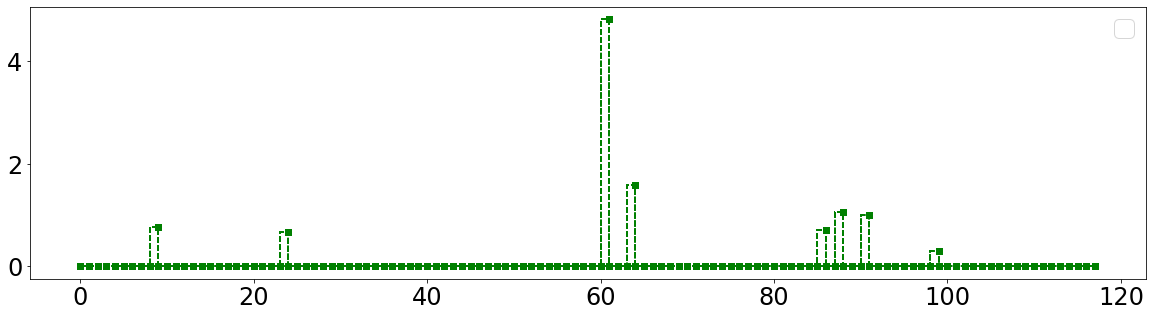

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
for i in range(rpData.shape[0]):
    ax.step(range(numBuses), rpData[0, :], 'g--s')
    ax.step(range(numBuses), -rdData[0, :], 'g--s')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.legend(fontsize=24)
plt.show()